# Introduction

This project aims to develop a machine learning model to predict the ESRB ratings of video games based on their content descriptors. We used two datasets: one from Kaggle ("Video Games Rating By 'ESRB'") and another created through the SteamAPI. The goal is to demonstrate the effectiveness of various machine learning models, with and without dimensionality reduction using PCA, and to optimize the best-performing model.

## Dataset Overview

The dataset contains various features related to content descriptors and the ESRB rating as the target variable. Below are some key features:

- **title**: Name of the game.
- **console**: The console on which the game was released. 
  - 0 = PS4
  - 1 = PS4 & Xbox One
- **Alcohol_Reference**: Reference to and/or images of alcoholic beverages.
  - 0 = No
  - 1 = Yes
- **Animated_Blood**: Discolored and/or unrealistic depictions of blood.
  - 0 = No
  - 1 = Yes
- **Blood**: Depictions of blood.
  - 0 = No
  - 1 = Yes
- **Blood_and_Gore**: Depictions of blood or the mutilation of body parts.
  - 0 = No
  - 1 = Yes
- **Cartoon_Violence**: Violent actions involving cartoon-like situations and characters. May include violence where a character is unharmed after the action has been inflicted.
  - 0 = No
  - 1 = Yes
- **Crude_Humor**: Depictions or dialogue involving vulgar antics, including "bathroom" humor.
  - 0 = No
  - 1 = Yes
- **Drug_Reference**: Reference to and/or images of illegal drugs.
  - 0 = No
  - 1 = Yes
- **ESRB_rating**: The ESRB rating of the game.
  - RP = Rating Pending
  - EC = Early Childhood
  - E = Everyone
  - E 10+ = Everyone 10+
  - T = Teen
  - M = Mature
  - A = Adult

**Note**: Not all possible ESRB ratings appear in our dataset. The labels present in our data include:
- E (Everyone) - Content is generally suitable for all ages. May contain minimal cartoon, fantasy or mild violence and/or infrequent use of mild language.
- E 10+ (Everyone 10+) - Content is generally suitable for ages 10 and up. May contain more cartoon, fantasy or mild violence, mild language and/or minimal suggestive themes.
- T (Teen) - Content is generally suitable for ages 13 and up. May contain violence, suggestive themes, crude humor, minimal blood, simulated gambling and/or infrequent use of strong language. 
- M (Mature 17+) - Content is generally suitable for ages 17 and up. May contain intense violence, blood and gore, sexual content and/or strong language.

In this project, we will focus on predicting these ratings based on the content descriptors provided in the dataset.


# Data Loading and Initial Inspection
We begin by loading the dataset and performing an initial inspection to understand its structure and the types of features it contains. This step includes displaying the first few rows of the dataset and summarizing its columns and data types.

In [163]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the data
train_data = pd.read_csv('../data/kaggle_train_esrb.csv')
test_data = pd.read_csv('../data/kaggle_test_esrb.csv')

# merge the two datasets
train_data = pd.concat([train_data, test_data], ignore_index=True)

print("shape of train data")
print(train_data.shape)

print("shape of test data")
print(test_data.shape)

# Display the first few rows and columns
train_data.head()

shape of train data
(2395, 34)
shape of test data
(500, 34)


title  console  alcohol_reference  \
0         Monster Jam Steel Titans 2        1                  0   
1             Subnautica: Below Zero        1                  0   
2  NIER REPLICANT VER.1.22474487139…        1                  0   
3                         Jamestown+        0                  0   
4             Neptunia Virtual Stars        0                  0   

   animated_blood  blood  blood_and_gore  cartoon_violence  crude_humor  \
0               0      0               0                 0            0   
1               1      0               0                 0            0   
2               0      1               0                 0            0   
3               0      0               0                 0            0   
4               0      0               0                 0            0   

   drug_reference  fantasy_violence  ...  sexual_content  sexual_themes  \
0               0                 0  ...               0              0   
1               0                 0  ...               0              0   
2               0                 0  ...               0              0   
3               0                 1  ...               0              0   
4               0                 1  ...               0              0   

   simulated_gambling  strong_language  strong_sexual_content  \
0                   0                0                      0   
1                   0                0                      0   
2                   0                1                      0   
3                   0                0                      0   
4                   0                0                      0   

   suggestive_themes  use_of_alcohol  use_of_drugs_and_alcohol  violence  \
0                  0               0                         0         0   
1                  0               0                         0         0   
2                  1               0                         0         0   
3                  0               0                         0         0   
4                  1               0                         0         0   

   esrb_rating  
0            E  
1           ET  
2            M  
3           ET  
4            T  

[5 rows x 34 columns]

# Data Statistics and Distributions

We explore the statistical properties of the dataset and visualize the distributions of key features. Understanding the data's characteristics is essential for feature selection, model development, and gaining insights into the underlying patterns.

Unique values: Index(['E', 'ET', 'M', 'T'], dtype='object', name='esrb_rating')
Counts: [477 477 477 477]
shape of updated train data
(1908, 34)


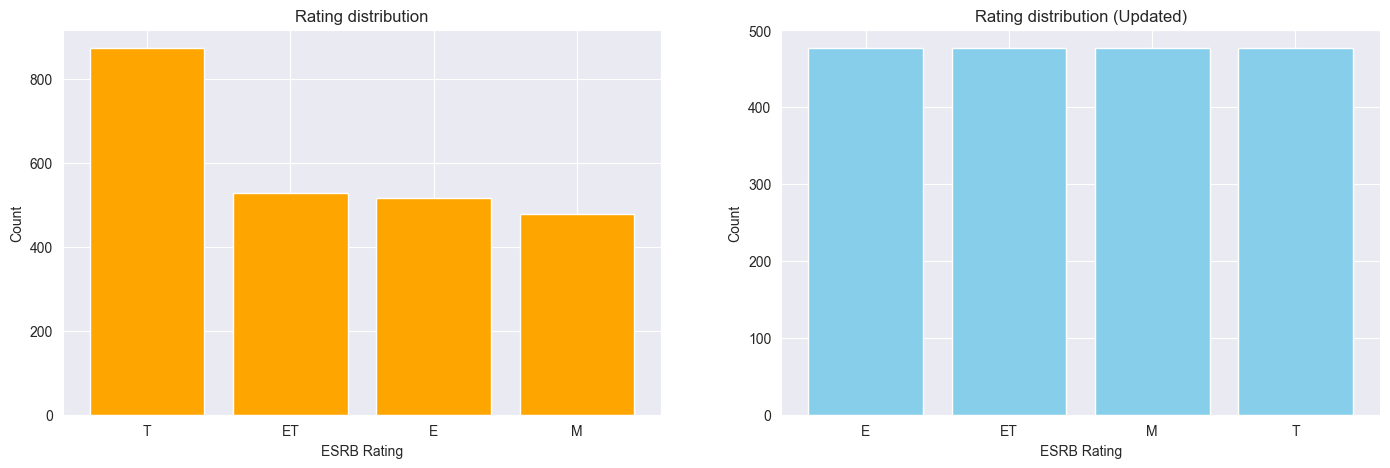

In [164]:
 # Get unique values and their counts

unique_values = test_data['esrb_rating'].value_counts().index
counts = train_data['esrb_rating'].value_counts().values

plt.figure(figsize=(17, 5))
# Bar graph
plt.subplot(1, 2, 1)
plt.bar(unique_values, counts, color='orange')
plt.title(f'Rating distribution')
plt.xlabel('ESRB Rating')
plt.ylabel('Count')
plt.grid(True)

# get the lowest count of a label
min_count = min(counts)
# Adjust the train data to be equally distributed within labels
train_data_group = train_data.groupby('esrb_rating').head(min_count)

# Create a figure with the updated distribution
unique_values = train_data_group['esrb_rating'].value_counts().index
counts = train_data_group['esrb_rating'].value_counts().values

# print the number of unique values and their counts after updating the distribution
print("Unique values:", unique_values)
print("Counts:", counts)

# shape of the updated train data
print("shape of updated train data")
print(train_data_group.shape)

plt.subplot(1, 2, 2)
plt.bar(unique_values, counts, color='skyblue')
plt.title(f'Rating distribution (Updated)')
plt.xlabel('ESRB Rating')
plt.ylabel('Count')
plt.grid(True)

# Show the plots
plt.show()

## Correlation Analysis

### Interpretation of Correlation Results

In this analysis, we examined the correlations between various features of video games and their ESRB ratings. Correlation values range from -1 to 1, where values close to 1 or -1 indicate strong correlations, and values near 0 indicate weak correlations. 
Positive correlation in this dataset will indicate that they are more likely to have a higher ESRB rating, for example, high correlation of blood and gore with the esrb rating will indicate that it will contribute to a higher ESRB rating, in this case M or T.




top 3 positive correlations
strong_language    0.464702
blood_and_gore     0.457472
blood              0.425306
Name: esrb_rating, dtype: float64

top 3 negative correlations
no_descriptors          -0.519729
mild_fantasy_violence   -0.296343
mild_cartoon_violence   -0.102886
Name: esrb_rating, dtype: float64


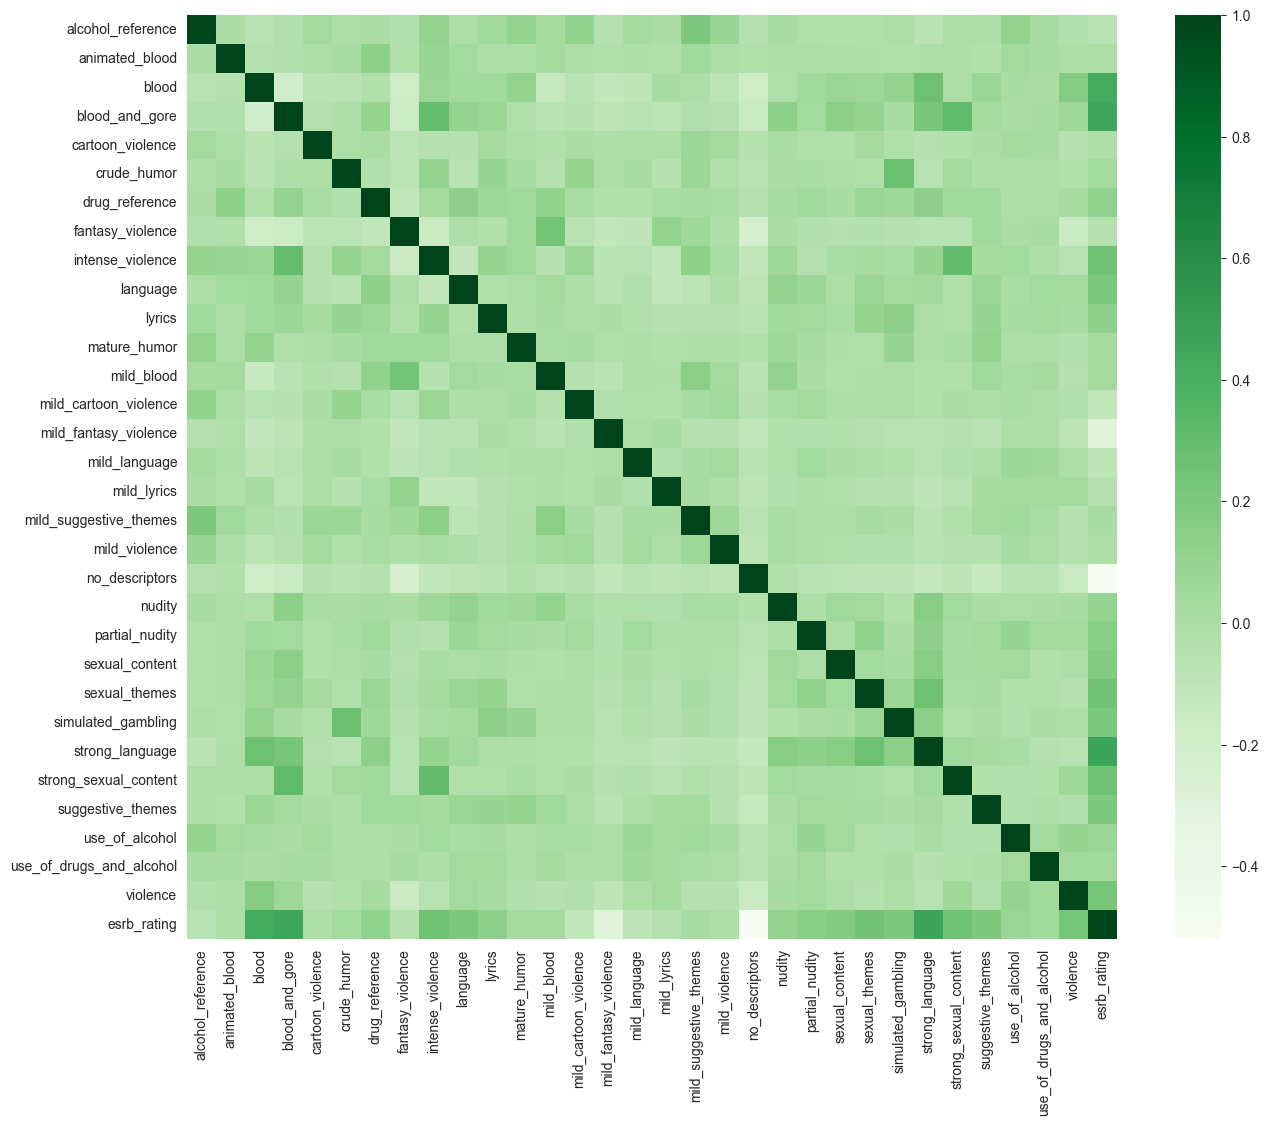

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

kaggle_train_df_copy = train_data.copy()

# correlation
# size
plt.figure(figsize=(15, 12))

useless_cols = ["title", "console"]
corr_data = train_data.drop(useless_cols, axis=1)

encode = {'E': 0,
          'ET': 1,
          'T': 2,
          'M': 3}

corr_data["esrb_rating"] = corr_data["esrb_rating"].map(encode)

corr_cols = list(corr_data.columns)

main_correlation = corr_data[corr_cols].corr()
sns.heatmap(main_correlation, annot=False, cmap="Greens")

top_3_positive_correlations = main_correlation['esrb_rating'].sort_values(ascending=False)[1:4]
top_3_negative_correlations = main_correlation['esrb_rating'].sort_values(ascending=True)[:3]
print("top 3 positive correlations")
print(top_3_positive_correlations)

print("\ntop 3 negative correlations")
print(top_3_negative_correlations)



### Overall Correlation Insights

These correlations reveal that certain content features have a significant influence on the ESRB rating of a game. Strong language and violent content, such as blood and gore, are key factors that contribute to higher ratings, which are intended to shield younger audiences from mature themes. On the other hand, the presence of "no descriptors" is strongly associated with lower ESRB ratings.

Understanding these correlations can assist game developers in making informed decisions about the content they include, depending on their target audience. For instance, if a developer intends to create a game for a broad audience, they might opt to avoid strong language and graphic violence to achieve a lower ESRB rating.

# Data Cleaning and Preprocessing

### Remove duplicates and null values.

In [166]:
# Check for duplicates and NaN values
print("Number of duplicates in train data:", test_data.duplicated().sum())

# Check for null values
print("Null values in train data:")
print(test_data.isnull().sum())

Number of duplicates in train data: 3
Null values in train data:
title                       0
console                     0
alcohol_reference           0
animated_blood              0
blood                       0
blood_and_gore              0
cartoon_violence            0
crude_humor                 0
drug_reference              0
fantasy_violence            0
intense_violence            0
language                    0
lyrics                      0
mature_humor                0
mild_blood                  0
mild_cartoon_violence       0
mild_fantasy_violence       0
mild_language               0
mild_lyrics                 0
mild_suggestive_themes      0
mild_violence               0
no_descriptors              0
nudity                      0
partial_nudity              0
sexual_content              0
sexual_themes               0
simulated_gambling          0
strong_language             0
strong_sexual_content       0
suggestive_themes           0
use_of_alcohol              0
use_o

## Cleaning the data from non-numeric values
Remove the non-numeric values from the data, such as 'title' and 'esrb_rating'.

In [167]:
train_x = train_data.drop(['title', 'esrb_rating'], axis=1)
# clean_data.set_index('title', inplace=True)
train_y = train_data['esrb_rating']

train_x.head()

console  alcohol_reference  animated_blood  blood  blood_and_gore  \
0        1                  0               0      0               0   
1        1                  0               1      0               0   
2        1                  0               0      1               0   
3        0                  0               0      0               0   
4        0                  0               0      0               0   

   cartoon_violence  crude_humor  drug_reference  fantasy_violence  \
0                 0            0               0                 0   
1                 0            0               0                 0   
2                 0            0               0                 0   
3                 0            0               0                 1   
4                 0            0               0                 1   

   intense_violence  ...  partial_nudity  sexual_content  sexual_themes  \
0                 0  ...               0               0              0   
1                 1  ...               0               0              0   
2                 0  ...               0               0              0   
3                 0  ...               0               0              0   
4                 0  ...               0               0              0   

   simulated_gambling  strong_language  strong_sexual_content  \
0                   0                0                      0   
1                   0                0                      0   
2                   0                1                      0   
3                   0                0                      0   
4                   0                0                      0   

   suggestive_themes  use_of_alcohol  use_of_drugs_and_alcohol  violence  
0                  0               0                         0         0  
1                  0               0                         0         0  
2                  1               0                         0         0  
3                  0               0                         0         0  
4                  1               0                         0         0  

[5 rows x 32 columns]

## Scaling the data

In [168]:
# scale the data
scaler = StandardScaler()
df_scaled_data = scaler.fit_transform(train_x)
df_scaled_data

array([[ 1.04222691, -0.23067337, -0.09176629, ..., -0.17730881,
        -0.15331104, -0.36016244],
       [ 1.04222691, -0.23067337, 10.89724736, ..., -0.17730881,
        -0.15331104, -0.36016244],
       [ 1.04222691, -0.23067337, -0.09176629, ..., -0.17730881,
        -0.15331104, -0.36016244],
       ...,
       [-0.95948396, -0.23067337, -0.09176629, ...,  5.63987759,
        -0.15331104, -0.36016244],
       [-0.95948396, -0.23067337, -0.09176629, ..., -0.17730881,
        -0.15331104, -0.36016244],
       [ 1.04222691, -0.23067337, -0.09176629, ..., -0.17730881,
        -0.15331104,  2.77652497]])

# PCA Analysis

## Applying PCA

In [169]:
pca = PCA(n_components=0.8)
train_pca_data = pca.fit_transform(df_scaled_data)
train_pca_x = pd.DataFrame(data=train_pca_data)
train_pca_x.head()

0         1         2         3         4         5         6   \
0 -1.082557  0.705899 -1.618361  0.591902 -0.826568  0.597334 -0.764594   
1  0.553281  3.556278  2.426240 -0.372305  0.731712  1.703850 -1.150877   
2  1.600211 -1.862395 -0.460867 -0.792332 -0.232378 -0.722172 -1.143268   
3 -1.122424 -1.665887  2.617976  1.855320 -0.649331  0.570534  0.636313   
4 -0.519033 -1.913915  1.584352  0.864195 -0.417131 -0.333305  0.258512   

         7         8         9   ...        12        13        14        15  \
0  0.511417 -0.349496 -0.645067  ... -0.673792  0.151855  0.403865  0.149193   
1  3.660390 -4.218187  5.510795  ... -0.271051 -0.907687  0.965888 -0.749275   
2 -0.166175 -0.713306 -0.233901  ... -0.240448 -1.115285  0.521927  0.142144   
3  0.900799  0.643562 -0.477115  ...  0.232558  0.235590 -0.509435 -0.230343   
4  0.874460  1.575846 -0.152342  ... -0.177702 -0.638727 -0.272576  1.019377   

         16        17        18        19        20        21  
0 -0.163747  0.330158  0.142239  0.099918 -0.123278 -0.460666  
1  4.484431 -1.496143  1.746404 -0.166809 -2.215269  1.336747  
2  0.983583 -0.729796  1.164561  0.665617 -0.846977 -1.463544  
3  0.212288 -1.144899 -0.707330 -0.265772  0.539917 -0.345246  
4  1.451101 -1.189412 -1.103232 -0.574169 -1.175661 -0.323468  

[5 rows x 22 columns]

###### needing 22 PCA components to retain 80% of the variance suggests that our dataset is complex, with many features contributing essential information. This limits the effectiveness of PCA for significant dimensionality reduction.

###### We'll still proceed with using the 22 PCA components and compare the results to those obtained with the original dataset without PCA. This comparison will help us evaluate whether the dimensionality reduction through PCA provides any performance benefits or if the original dataset, despite its complexity, yields better results.

## Explained Variance

In [170]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

## Plotting the explained variance

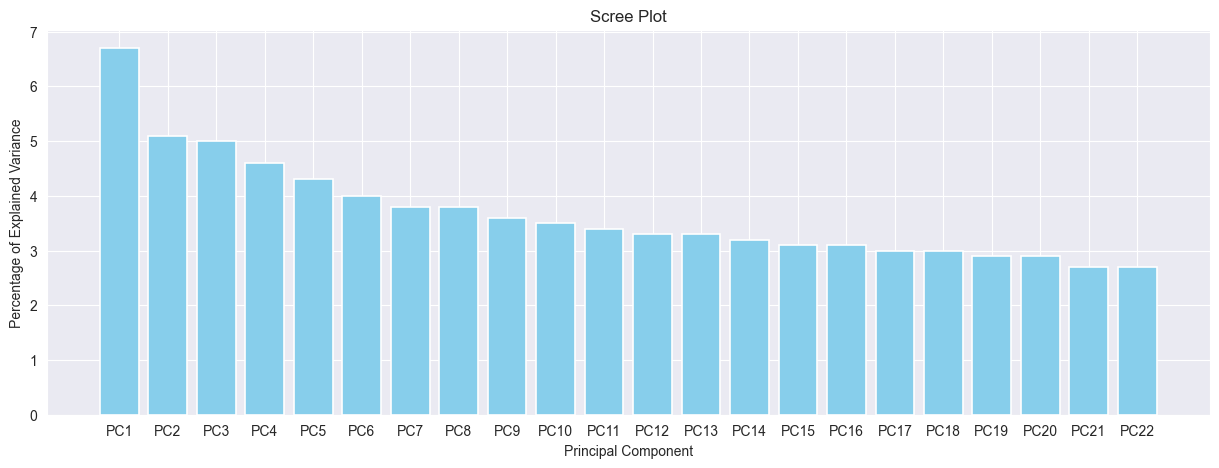

In [171]:
## Plotting the explained variance, make it wide enough so the var labels are readable
plt.figure(figsize=(15, 5))
plt.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels, color='skyblue', linewidth=1.2)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

## PCA Components

In [172]:
train_pca_x = pd.DataFrame(train_pca_data, columns=labels)

train_pca_x
# pca_df.shape

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -1.082557  0.705899 -1.618361  0.591902 -0.826568  0.597334 -0.764594   
1     0.553281  3.556278  2.426240 -0.372305  0.731712  1.703850 -1.150877   
2     1.600211 -1.862395 -0.460867 -0.792332 -0.232378 -0.722172 -1.143268   
3    -1.122424 -1.665887  2.617976  1.855320 -0.649331  0.570534  0.636313   
4    -0.519033 -1.913915  1.584352  0.864195 -0.417131 -0.333305  0.258512   
...        ...       ...       ...       ...       ...       ...       ...   
2390  1.793655  2.236447 -0.300307  1.072782  0.140144 -0.730154  0.351061   
2391  0.884421 -1.581216 -0.898217 -1.119402  1.255729  1.294863 -0.527134   
2392  2.219251 -0.118816  0.101564 -1.349201  2.425698 -0.748621 -1.552502   
2393 -1.746741  0.095750  4.201187  0.612692 -0.477778 -0.341005 -0.137860   
2394  0.323227 -0.764007 -1.504924 -1.098105  1.647228 -0.501831  0.182800   

           PC8       PC9      PC10  ...      PC13      PC14      PC15  \
0     0.511417 -0.349496 -0.645067  ... -0.673792  0.151855  0.403865   
1     3.660390 -4.218187  5.510795  ... -0.271051 -0.907687  0.965888   
2    -0.166175 -0.713306 -0.233901  ... -0.240448 -1.115285  0.521927   
3     0.900799  0.643562 -0.477115  ...  0.232558  0.235590 -0.509435   
4     0.874460  1.575846 -0.152342  ... -0.177702 -0.638727 -0.272576   
...        ...       ...       ...  ...       ...       ...       ...   
2390 -0.026886 -0.154097 -0.011591  ... -0.375231 -0.162022  0.049344   
2391 -0.646896  0.686104 -0.005550  ... -2.704218  0.402788  1.693560   
2392 -1.191160 -0.529511  0.934674  ... -0.747027  1.424331  1.645910   
2393 -0.285653 -1.618378  0.090348  ... -0.905499 -0.306422 -0.856136   
2394  1.196102 -0.804337 -0.807393  ...  0.488372 -0.020715 -0.528020   

          PC16      PC17      PC18      PC19      PC20      PC21      PC22  
0     0.149193 -0.163747  0.330158  0.142239  0.099918 -0.123278 -0.460666  
1    -0.749275  4.484431 -1.496143  1.746404 -0.166809 -2.215269  1.336747  
2     0.142144  0.983583 -0.729796  1.164561  0.665617 -0.846977 -1.463544  
3    -0.230343  0.212288 -1.144899 -0.707330 -0.265772  0.539917 -0.345246  
4     1.019377  1.451101 -1.189412 -1.103232 -0.574169 -1.175661 -0.323468  
...        ...       ...       ...       ...       ...       ...       ...  
2390 -0.058191  0.308871  0.146405  0.300846 -0.534651 -0.610118 -0.513719  
2391 -1.050772 -0.604416 -0.926893  1.143627  0.594398  1.295871 -1.806267  
2392 -0.338879  0.081877 -1.071101  0.927038 -2.015237 -0.302865 -0.398675  
2393 -0.618892 -0.232959 -1.046564 -0.998288  1.753667  1.389304 -0.872171  
2394 -0.195442 -0.385490 -0.957305  0.220415  0.613466  0.518258  0.209733  

[2395 rows x 22 columns]

# Plotting the PCA components

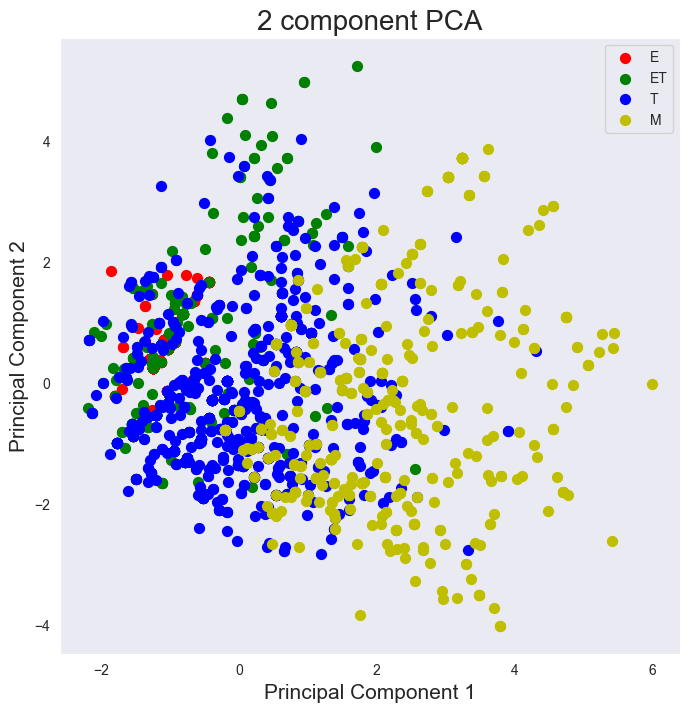

In [173]:
# Reset the index of train_y to ensure it aligns with pca_df_with_labels
train_y = train_y.reset_index(drop=True)
pca_df_with_labels = pd.concat([train_pca_x.reset_index(drop=True), train_y], axis=1)

pca_df_with_labels.head()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Principal Component 1", fontsize=15)
ax.set_ylabel("Principal Component 2", fontsize=15)
ax.set_title('2 component PCA', fontsize=20)
targets = ["E", "ET", "T", "M"]
colors = ["r", "g", "b", "y"]

for target, color in zip(targets, colors):
    indicesToKeep = pca_df_with_labels[train_y.name] == target
    ax.scatter(pca_df_with_labels.loc[indicesToKeep, "PC1"],
               pca_df_with_labels.loc[indicesToKeep, "PC2"],
               c=color,
               s=50)

ax.legend(targets)
ax.grid()
plt.show()


## PCA Component Interpretation
While there is some overlap between the categories, particularly between "T" and "M", we can observe that certain ratings tend to cluster together, suggesting that these principal components do capture some of the underlying differences between the ratings. However, the overlap also indicates that the first two components alone may not be sufficient to fully distinguish between all the ESRB ratings, reinforcing the need to consider additional components or features in the model.

## Loading Scores

In [174]:
loading_scores = pd.Series(pca.components_[0], index=train_x.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
top_10_features = sorted_loading_scores[0:10].index.values
loading_scores[top_10_features]

blood_and_gore           0.413967
strong_language          0.404722
intense_violence         0.324159
strong_sexual_content    0.280236
sexual_themes            0.248565
no_descriptors          -0.217485
fantasy_violence        -0.214597
blood                    0.208717
drug_reference           0.188998
simulated_gambling       0.183044
dtype: float64

The loading scores reveal which features have the most significant influence on the first principal component, and thus, on the overall variance captured by this component. The features with the highest loading scores, such as Blood and Gore, Strong Language, and Intense Violence, are those that heavily impact the first principal component, indicating their strong association with the variance in the dataset.

Interestingly, features like Fantasy Violence and No Descriptors have negative loading scores, meaning they contribute in the opposite direction compared to others like Blood and Gore. This suggests that games with more intense content (e.g., strong language, blood, and gore) are differentiated from those with milder or absent descriptors.

Overall, these results highlight the importance of specific content features in explaining the variation among games, particularly those related to mature and intense content, which aligns with their impact on ESRB ratings.

# Machine Learning Models
The chosen machine learning models are:
- K-Nearest Neighbors (KNN): Good for capturing local patterns in data, which might help differentiate similar games based on content.

- Decision Tree Classifier: Handles both numerical and categorical features well, making it useful for interpreting complex interactions in our dataset.

- Logistic Regression: Provides a straightforward, interpretable model for binary classification, ideal for distinguishing between ratings if grouped.

- Support Vector Machine (SVM): Effective for high-dimensional data, like ours, and can separate complex boundaries between different ESRB ratings.

In [175]:
from sklearn.model_selection import train_test_split

# Split the PCA-transformed training data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(train_pca_x, train_y, test_size=0.2, random_state=42)

# Split the original training data into training and validation sets
OX_train, OX_test, OY_train, OY_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

labels = ["M", "T", "ET", "E"]

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


## Logistic Regression

PCA Test Accuracy: 0.81
              precision    recall  f1-score   support

           E       0.92      0.93      0.93       107
          ET       0.67      0.71      0.69        97
           M       0.84      0.87      0.85        89
           T       0.82      0.77      0.79       186

    accuracy                           0.81       479
   macro avg       0.81      0.82      0.81       479
weighted avg       0.81      0.81      0.81       479

Original Test Accuracy: 0.84
              precision    recall  f1-score   support

           E       0.94      0.99      0.96       107
          ET       0.71      0.74      0.73        97
           M       0.86      0.87      0.86        89
           T       0.83      0.78      0.81       186

    accuracy                           0.84       479
   macro avg       0.84      0.85      0.84       479
weighted avg       0.84      0.84      0.84       479



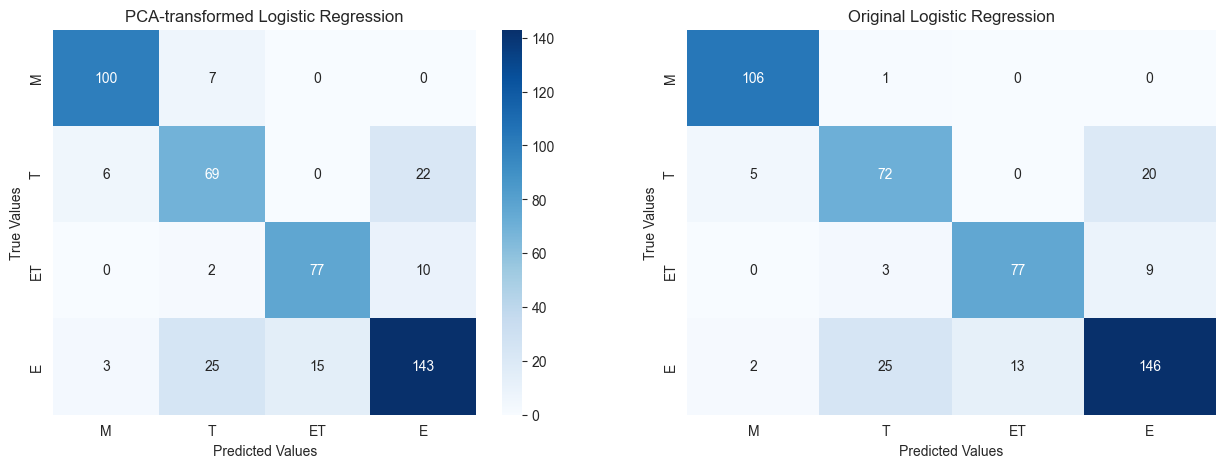

In [176]:
# Train a logistic regression model on the PCA-transformed training data
log_reg_pca = LogisticRegression()
log_reg_original = LogisticRegression()

# Fit the PCA-transformed training data
log_reg_pca.fit(X_train, y_train)

# Fit the original training data
log_reg_original.fit(OX_train, OY_train)



# ------------- Testing the model -------------
# test the model on the PCA-transformed test data
y_test_pred = log_reg_pca.predict(X_test)
# test the model on the original test data
o_y_test_pred = log_reg_original.predict(OX_test)

# If y_test is available, evaluate the model
if y_test is not None:
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f'PCA Test Accuracy: {test_accuracy:.2f}')
    print(classification_report(y_test, y_test_pred))

    test_accuracy = accuracy_score(OY_test, o_y_test_pred)
    print(f'Original Test Accuracy: {test_accuracy:.2f}')
    print(classification_report(OY_test, o_y_test_pred))

# ------------- Confusion Matrix -------------
# # Plot the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# PCA-transformed model, use the labels dictionary to display the labels in the correct order
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('PCA-transformed Logistic Regression')
ax[0].set_xticklabels(labels)
ax[0].set_yticklabels(labels)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('True Values')

# Original model
cm = confusion_matrix(OY_test, o_y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Blues', ax=ax[1])
ax[1].set_title('Original Logistic Regression')
ax[1].set_xticklabels(labels)
ax[1].set_yticklabels(labels)
ax[1].set_xlabel('Predicted Values')
ax[1].set_ylabel('True Values')
plt.show()


### Logistic Regression Results
- Both models show strong performance, particularly in predicting "E" and "M" ratings.
- The original data model performs better overall, suggesting that while PCA helped reduce dimensionality, it might have also removed some informative variance crucial for making more accurate predictions, let's see if this is the case with other models.

## Decision Tree

PCA Test Accuracy: 0.84
              precision    recall  f1-score   support

           E       0.97      0.99      0.98       107
          ET       0.77      0.74      0.75        97
           M       0.81      0.84      0.82        89
           T       0.81      0.80      0.80       186

    accuracy                           0.84       479
   macro avg       0.84      0.84      0.84       479
weighted avg       0.84      0.84      0.84       479

Original Test Accuracy: 0.85
              precision    recall  f1-score   support

           E       0.95      0.99      0.97       107
          ET       0.79      0.82      0.81        97
           M       0.80      0.85      0.83        89
           T       0.84      0.78      0.81       186

    accuracy                           0.85       479
   macro avg       0.85      0.86      0.85       479
weighted avg       0.85      0.85      0.85       479



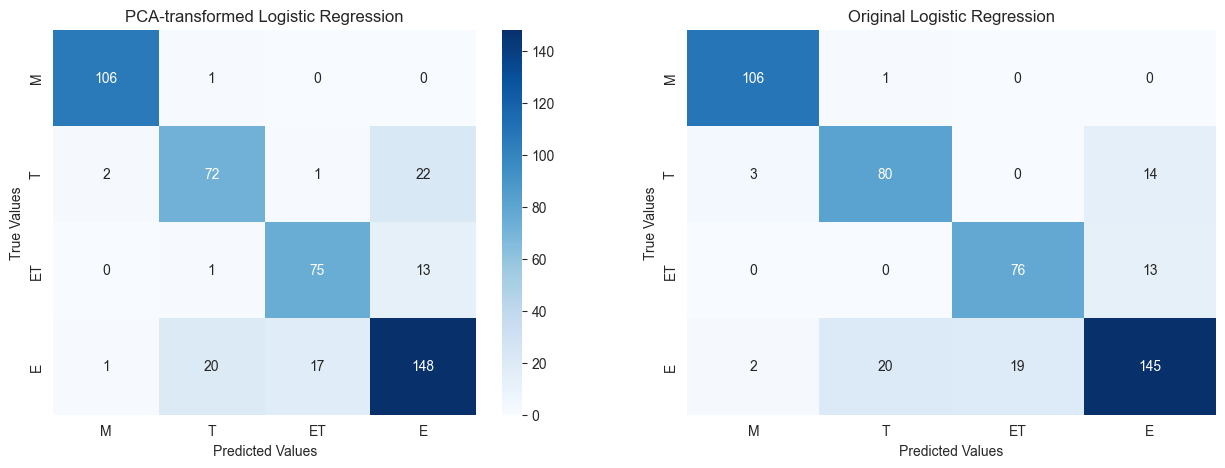

In [177]:
# Initialize Decision Tree models
dt_pca = DecisionTreeClassifier()
dt_original = DecisionTreeClassifier()

# Fit the PCA-transformed training data
dt_pca.fit(X_train, y_train)

# Fit the original training data
dt_original.fit(OX_train, OY_train)

# ------------- Testing the model -------------
# Test the model on the PCA-transformed test data
y_test_pred = dt_pca.predict(X_test)

# Test the model on the original test data
o_y_test_pred = dt_original.predict(OX_test)

# If y_test is available, evaluate the model
if y_test is not None:
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f'PCA Test Accuracy: {test_accuracy:.2f}')
    print(classification_report(y_test, y_test_pred))

    test_accuracy = accuracy_score(OY_test, o_y_test_pred)
    print(f'Original Test Accuracy: {test_accuracy:.2f}')
    print(classification_report(OY_test, o_y_test_pred))

# ------------- Confusion Matrix -------------
# # Plot the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# PCA-transformed model, use the labels dictionary to display the labels in the correct order
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('PCA-transformed Logistic Regression')
ax[0].set_xticklabels(labels)
ax[0].set_yticklabels(labels)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('True Values')

# Original model
cm = confusion_matrix(OY_test, o_y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Blues', ax=ax[1])
ax[1].set_title('Original Logistic Regression')
ax[1].set_xticklabels(labels)
ax[1].set_yticklabels(labels)
ax[1].set_xlabel('Predicted Values')
ax[1].set_ylabel('True Values')
plt.show()


### Decision Tree Results
- The original dataset model slightly outperforms the PCA-transformed version, particularly in the "ET" and "T" categories, where both precision and recall are higher.
- The "E" category continues to perform exceptionally well, indicating that this model effectively captures the features that define games rated "E."

## K-Nearest Neighbors (KNN)

PCA Test Accuracy: 0.79
              precision    recall  f1-score   support

           E       0.89      0.99      0.94       107
          ET       0.66      0.73      0.70        97
           M       0.78      0.80      0.79        89
           T       0.80      0.69      0.74       186

    accuracy                           0.79       479
   macro avg       0.78      0.80      0.79       479
weighted avg       0.79      0.79      0.78       479

Original Test Accuracy: 0.80
              precision    recall  f1-score   support

           E       0.85      0.99      0.91       107
          ET       0.70      0.75      0.72        97
           M       0.82      0.85      0.84        89
           T       0.83      0.69      0.75       186

    accuracy                           0.80       479
   macro avg       0.80      0.82      0.81       479
weighted avg       0.80      0.80      0.80       479



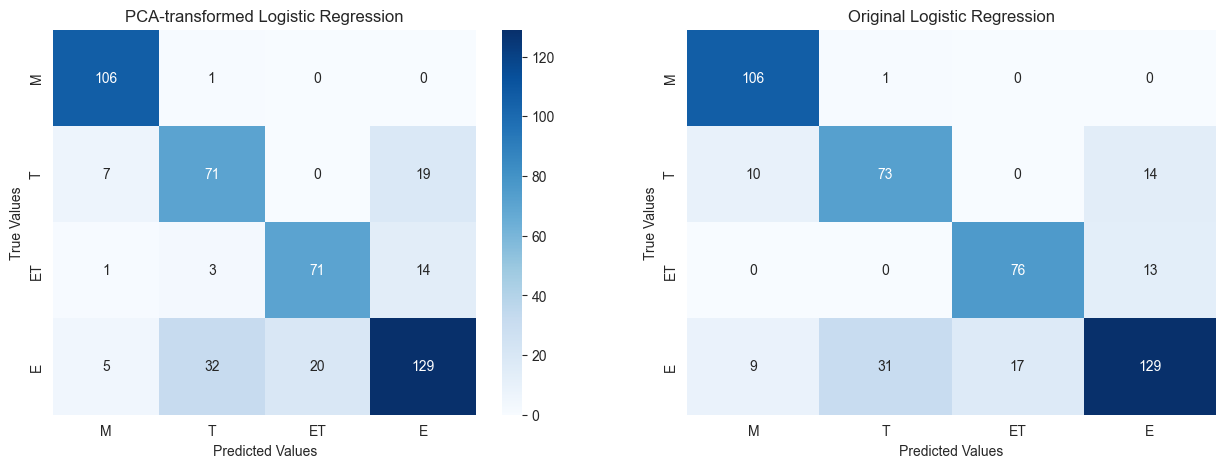

In [178]:


# Initialize KNN models
knn_pca = KNeighborsClassifier()
knn_original = KNeighborsClassifier()

# Fit the PCA-transformed training data
knn_pca.fit(X_train, y_train)

# Fit the original training data
knn_original.fit(OX_train, OY_train)

# ------------- Testing the model -------------
# Test the model on the PCA-transformed test data
y_test_pred = knn_pca.predict(X_test)

# Test the model on the original test data
o_y_test_pred = knn_original.predict(OX_test)

# If y_test is available, evaluate the model
if y_test is not None:
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f'PCA Test Accuracy: {test_accuracy:.2f}')
    print(classification_report(y_test, y_test_pred))

    test_accuracy = accuracy_score(OY_test, o_y_test_pred)
    print(f'Original Test Accuracy: {test_accuracy:.2f}')
    print(classification_report(OY_test, o_y_test_pred))

# ------------- Confusion Matrix -------------
# # Plot the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# PCA-transformed model, use the labels dictionary to display the labels in the correct order
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('PCA-transformed Logistic Regression')
ax[0].set_xticklabels(labels)
ax[0].set_yticklabels(labels)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('True Values')

# Original model
cm = confusion_matrix(OY_test, o_y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Blues', ax=ax[1])
ax[1].set_title('Original Logistic Regression')
ax[1].set_xticklabels(labels)
ax[1].set_yticklabels(labels)
ax[1].set_xlabel('Predicted Values')
ax[1].set_ylabel('True Values')
plt.show()



### K-Nearest Neighbors Results
- The original model shows a slight improvement in accuracy compared to the PCA-transformed model.


These results highlight that while KNN provides decent classification performance, the original dataset generally yields better results compared to the PCA-transformed data, similar to what we've seen with other models.

## Support Vector Machine (SVM)

PCA Test Accuracy: 0.84
              precision    recall  f1-score   support

           E       0.97      0.99      0.98       107
          ET       0.77      0.72      0.74        97
           M       0.82      0.87      0.84        89
           T       0.81      0.80      0.80       186

    accuracy                           0.84       479
   macro avg       0.84      0.84      0.84       479
weighted avg       0.84      0.84      0.84       479

Original Test Accuracy: 0.86
              precision    recall  f1-score   support

           E       0.98      0.99      0.99       107
          ET       0.80      0.74      0.77        97
           M       0.85      0.88      0.86        89
           T       0.82      0.83      0.83       186

    accuracy                           0.86       479
   macro avg       0.86      0.86      0.86       479
weighted avg       0.86      0.86      0.86       479



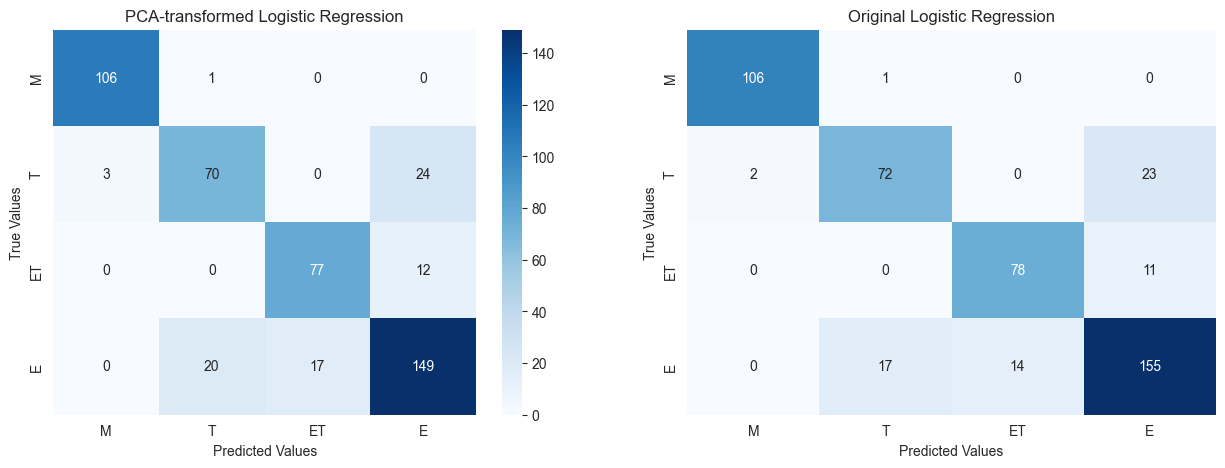

In [179]:
# Initialize SVM models
svm_pca = SVC()
svm_original = SVC()

# Fit the PCA-transformed training data
svm_pca.fit(X_train, y_train)

# Fit the original training data
svm_original.fit(OX_train, OY_train)

# ------------- Testing the model -------------
# Test the model on the PCA-transformed test data
y_test_pred = svm_pca.predict(X_test)

# Test the model on the original test data
o_y_test_pred = svm_original.predict(OX_test)

# If y_test is available, evaluate the model
if y_test is not None:
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f'PCA Test Accuracy: {test_accuracy:.2f}')
    print(classification_report(y_test, y_test_pred))

    test_accuracy = accuracy_score(OY_test, o_y_test_pred)
    print(f'Original Test Accuracy: {test_accuracy:.2f}')
    print(classification_report(OY_test, o_y_test_pred))

# ------------- Confusion Matrix -------------
# # Plot the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# PCA-transformed model, use the labels dictionary to display the labels in the correct order
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('PCA-transformed Logistic Regression')
ax[0].set_xticklabels(labels)
ax[0].set_yticklabels(labels)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('True Values')

# Original model
cm = confusion_matrix(OY_test, o_y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Blues', ax=ax[1])
ax[1].set_title('Original Logistic Regression')
ax[1].set_xticklabels(labels)
ax[1].set_yticklabels(labels)
ax[1].set_xlabel('Predicted Values')
ax[1].set_ylabel('True Values')
plt.show()


### Support Vector Machine Results
These results suggest that SVM is a strong classifier for this dataset, with both the PCA-transformed and original data yielding high accuracy and well-balanced classification performance.

# Feature Overlap Analysis

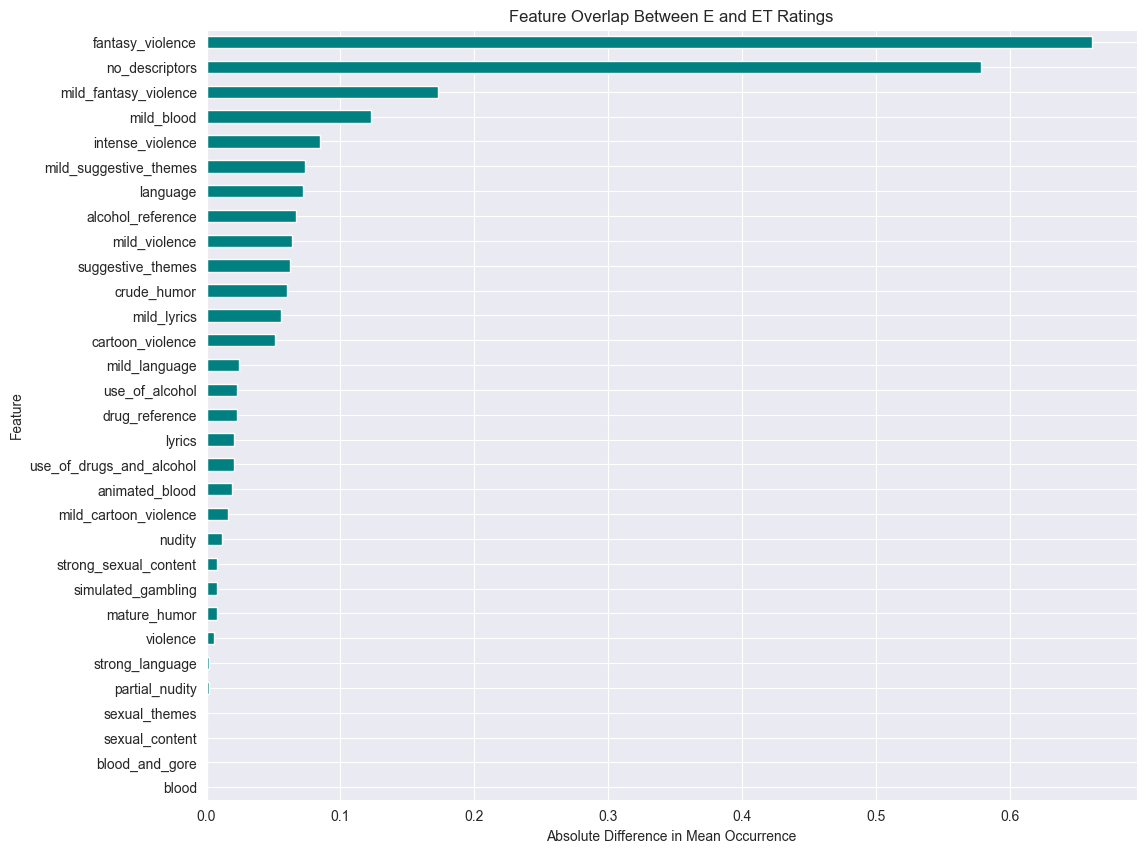

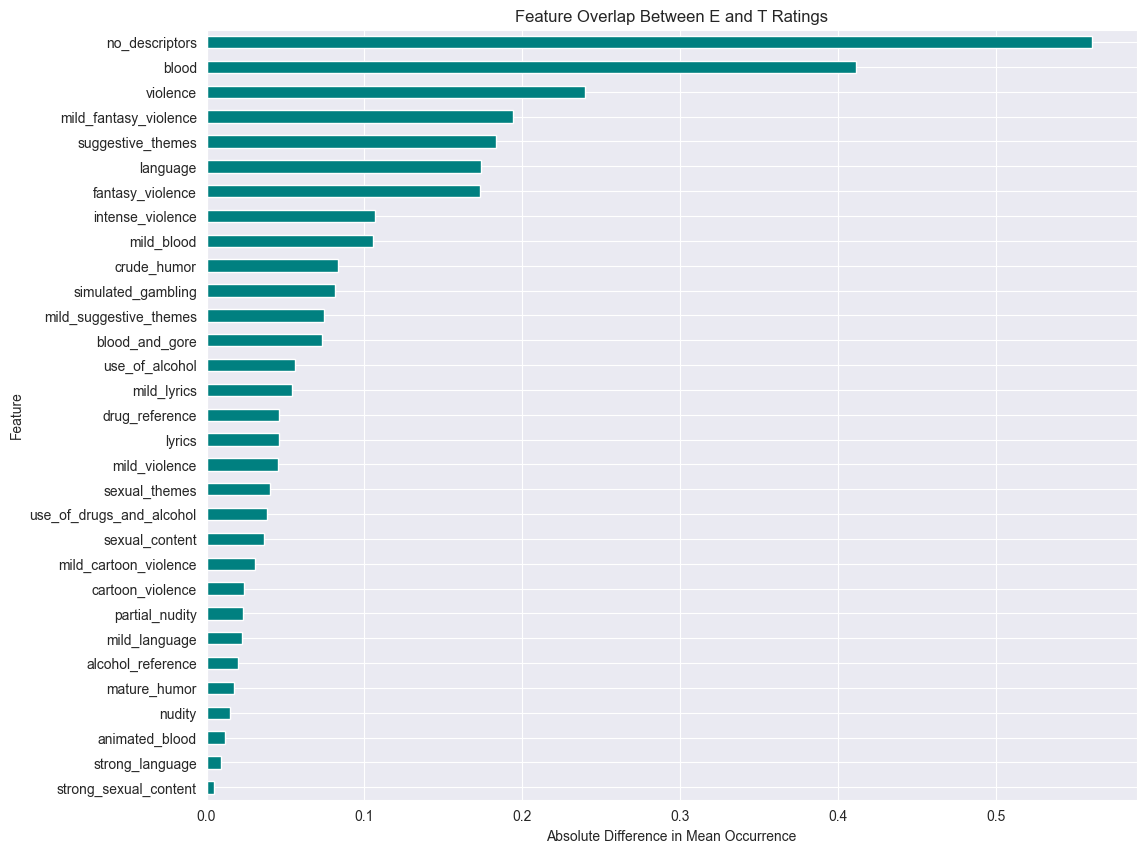

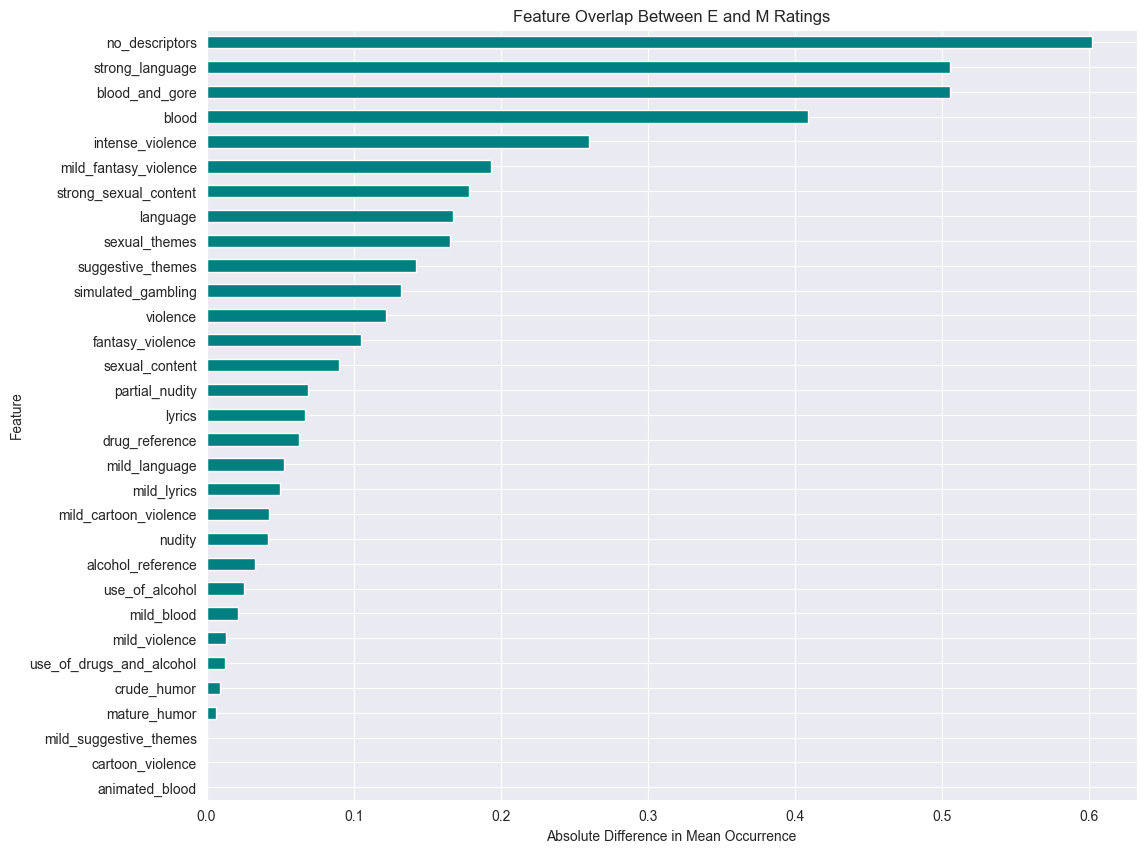

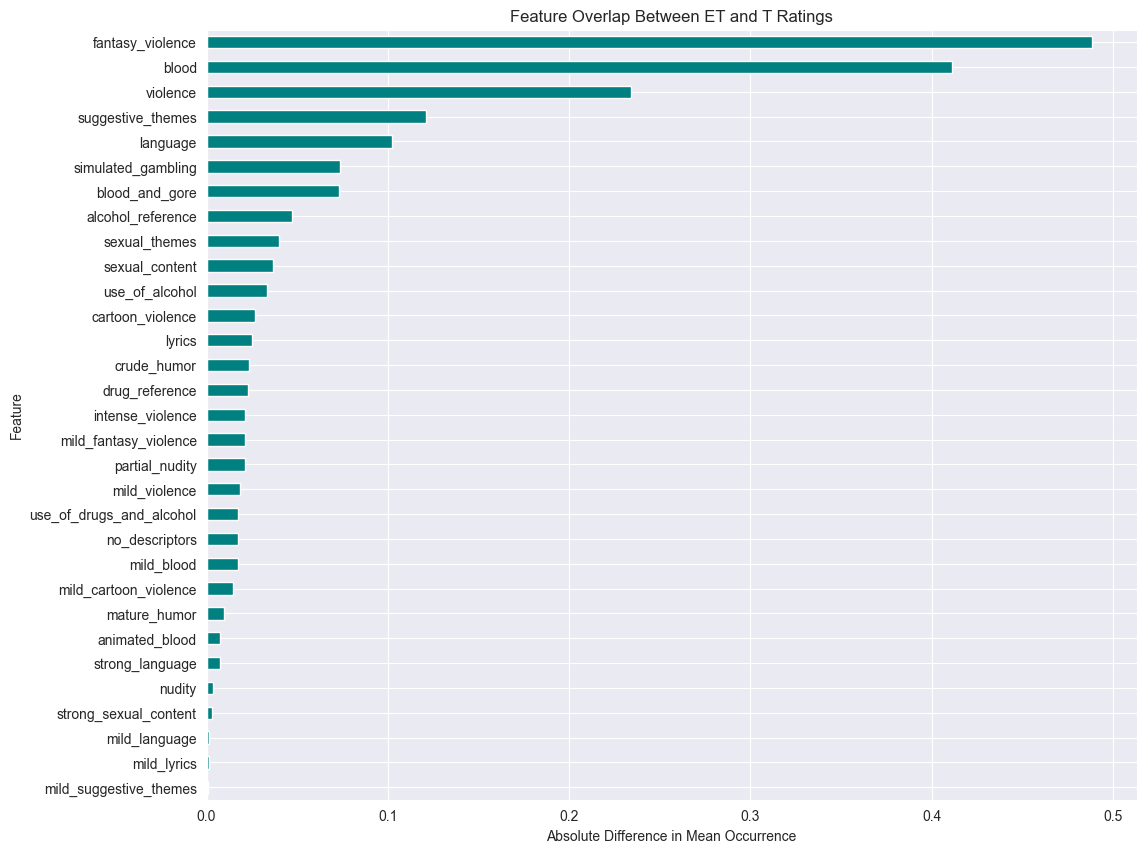

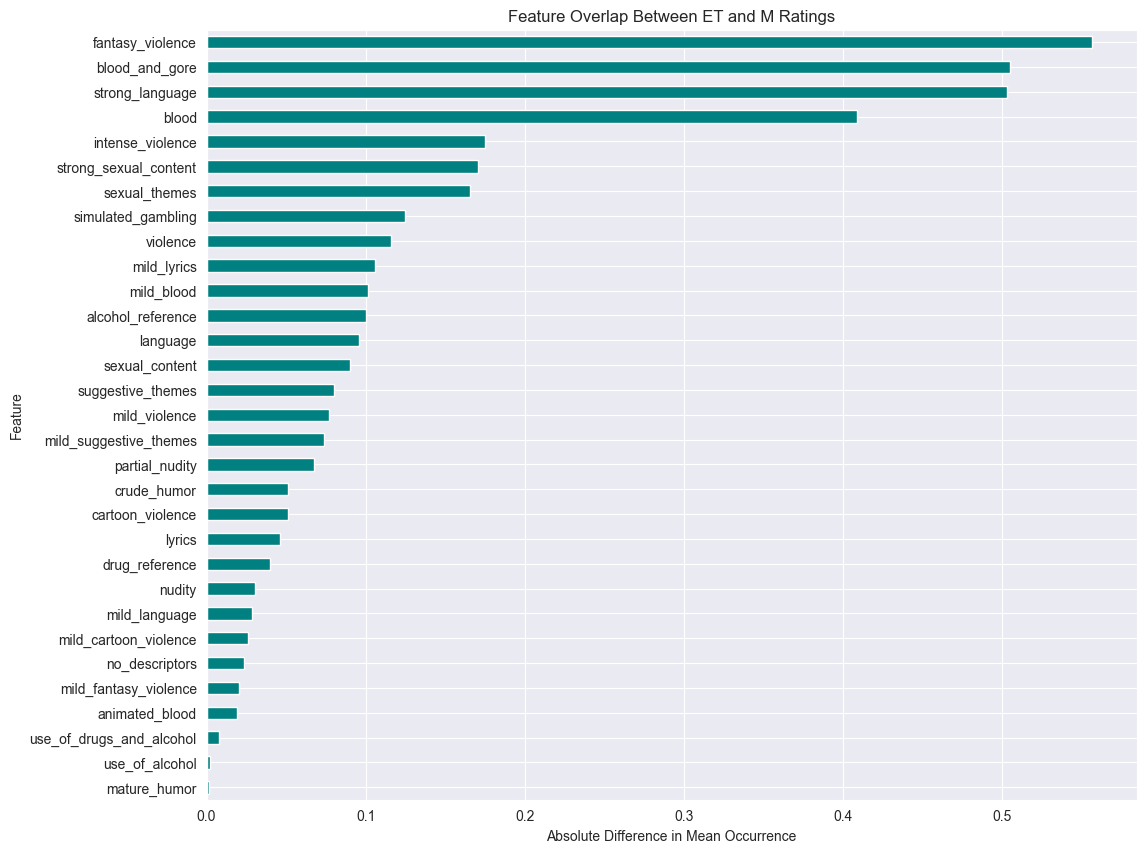

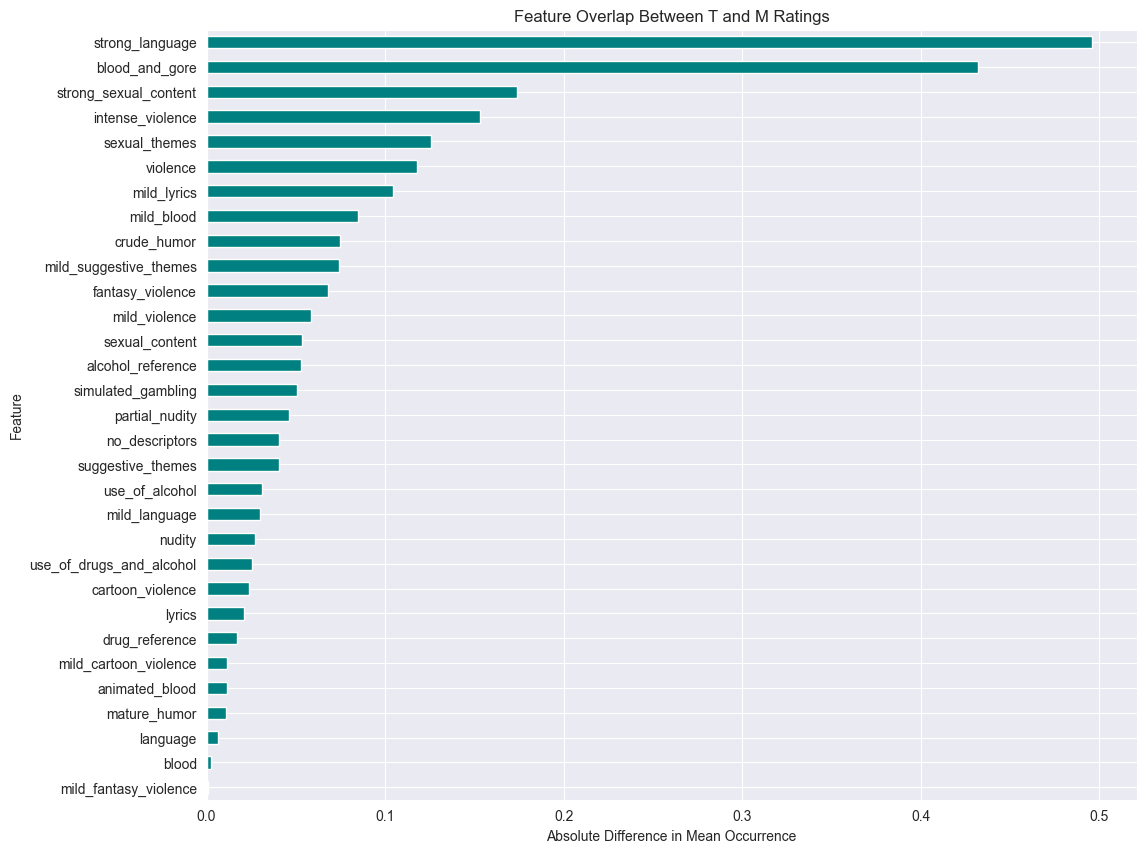

In [180]:
# Function to calculate and plot feature overlap between any two given ratings
def plot_feature_overlap(rating1, rating2, dataset, rating_names=None):
    # Filter the dataset for the given ratings
    filtered_data = dataset[dataset['esrb_rating'].isin([rating1, rating2])]

    # Calculate the mean occurrence of each feature for the two ratings
    mean_occurrences = filtered_data.groupby('esrb_rating').mean().transpose()

    # Calculate the absolute difference between the mean occurrences for the two ratings
    mean_occurrences['difference'] = abs(mean_occurrences[rating1] - mean_occurrences[rating2])

    # Sort by the smallest differences to find the most overlapping features
    sorted_mean_occurrences = mean_occurrences.sort_values(by='difference')

    # Set rating names for the plot title if provided
    rating1_name = rating_names[0] if rating_names else f"Rating {rating1}"
    rating2_name = rating_names[1] if rating_names else f"Rating {rating2}"

    # Plot the overlap of all features between the two ratings
    plt.figure(figsize=(12, 10))
    sorted_mean_occurrences['difference'].plot(kind='barh', color='teal')
    plt.title(f'Feature Overlap Between {rating1_name} and {rating2_name} Ratings')
    plt.xlabel('Absolute Difference in Mean Occurrence')
    plt.ylabel('Feature')
    plt.show()

# Run the function to plot the feature overlap between all pairs of ratings
ratings = [0, 1, 2, 3]
rating_names = ['E', 'ET', 'T', 'M']
# train_data.head()
# make esrb_rating a number
occurrences_data = train_data.copy().drop(['title', 'console'], axis=1)
occurrences_data['esrb_rating'] = occurrences_data['esrb_rating'].map(encode)
occurrences_data.head()
for i in range(len(ratings)):
    for j in range(i + 1, len(ratings)):
        plot_feature_overlap(ratings[i], ratings[j], occurrences_data, rating_names=[rating_names[i], rating_names[j]])


# Feature Importance Analysis


#### E vs. ET:
- High Overlap: Many features have small differences, indicating significant overlap between E and ET ratings. The similar content between these ratings makes it challenging for a model to differentiate between them

## Content-descriptor-based conclusion
### Summary of Results


In [181]:
import pandas as pd

# Create an empty list to store the results
results_list = []

# Logistic Regression
results_list.append({
    'Model': 'Logistic Regression',
    'Preprocessing': 'PCA',
    'Training Accuracy': accuracy_score(y_train, log_reg_pca.predict(X_train)),
    'Test Accuracy': accuracy_score(y_test, log_reg_pca.predict(X_test))
})

results_list.append({
    'Model': 'Logistic Regression',
    'Preprocessing': 'Original',
    'Training Accuracy': accuracy_score(OY_train, log_reg_original.predict(OX_train)),
    'Test Accuracy': accuracy_score(OY_test, log_reg_original.predict(OX_test))
})

# Decision Tree

results_list.append({
    'Model': 'Decision Tree',
    'Preprocessing': 'PCA',
    'Training Accuracy': accuracy_score(y_train, dt_pca.predict(X_train)),
    'Test Accuracy': accuracy_score(y_test, dt_pca.predict(X_test))
})

results_list.append({
    'Model': 'Decision Tree',
    'Preprocessing': 'Original',
    'Training Accuracy': accuracy_score(OY_train, dt_original.predict(OX_train)),
    'Test Accuracy': accuracy_score(OY_test, dt_original.predict(OX_test))
})

# K-Nearest Neighbors

results_list.append({
    'Model': 'K-Nearest Neighbors',
    'Preprocessing': 'PCA',
    'Training Accuracy': accuracy_score(y_train, knn_pca.predict(X_train)),
    'Test Accuracy': accuracy_score(y_test, knn_pca.predict(X_test))
})

results_list.append({
    'Model': 'K-Nearest Neighbors',
    'Preprocessing': 'Original',
    'Training Accuracy': accuracy_score(OY_train, knn_original.predict(OX_train)),
    'Test Accuracy': accuracy_score(OY_test, knn_original.predict(OX_test))
})

# Support Vector Machine

results_list.append({
    'Model': 'Support Vector Machine',
    'Preprocessing': 'PCA',
    'Training Accuracy': accuracy_score(y_train, svm_pca.predict(X_train)),
    'Test Accuracy': accuracy_score(y_test, svm_pca.predict(X_test))
})

results_list.append({
    'Model': 'Support Vector Machine',
    'Preprocessing': 'Original',
    'Training Accuracy': accuracy_score(OY_train, svm_original.predict(OX_train)),
    'Test Accuracy': accuracy_score(OY_test, svm_original.predict(OX_test))
})

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the results
print(results_df)

                    Model Preprocessing  Training Accuracy  Test Accuracy
0     Logistic Regression           PCA           0.839770       0.812109
1     Logistic Regression      Original           0.859603       0.837161
2           Decision Tree           PCA           0.930063       0.837161
3           Decision Tree      Original           0.930063       0.849687
4     K-Nearest Neighbors           PCA           0.868476       0.787056
5     K-Nearest Neighbors      Original           0.863257       0.801670
6  Support Vector Machine           PCA           0.903445       0.839248
7  Support Vector Machine      Original           0.906576       0.858038


### Model Performance Comparison
#### Observations:
- Logistic Regression: The original dataset performs better, showing higher training and test accuracy than the PCA-transformed data.

- Decision Tree: Both preprocessing methods achieve the same training accuracy, but the original data slightly outperforms PCA in test accuracy, indicating better generalization.

- K-Nearest Neighbors (KNN): The model trained on the original data has better test accuracy, though PCA achieves slightly higher training accuracy.

- Support Vector Machine (SVM): SVM performs well with both datasets, but the original dataset achieves slightly better results, especially in test accuracy.

### Summary
Overall, the original dataset tends to perform better than the PCA-transformed data, particularly in test accuracy, suggesting that while PCA can simplify the model and reduce dimensionality, it may also lose some critical information that affects the model's performance.

# Game Description Based Dataset from SteamAPI

#### The objective of this section is to create a dataset derived from game descriptions obtained via the SteamAPI. We will use this dataset to predict ESRB ratings using the same machine learning models applied previously. By comparing these results with those from the content-descriptor-based dataset, we aim to explore whether game descriptions alone can serve as effective predictors of ESRB ratings. This analysis will provide insights into the potential of game descriptions, which typically offer an overview of the game’s content, as a valuable feature for predicting ESRB ratings.

## Data Collection and Preprocessing

### Fetching Game Descriptions from SteamAPI

#### Helper Functions

In [182]:
from data_collection import *
from steam_apis import *

#### Fetching All Steam Apps and Game Descriptions


In [183]:
# File paths
apps_list_file_path = '../data/all_apps.csv'
games_descriptions_file_path = '../data/games_descriptions.csv'

# train_data.head()
print(train_data.shape)


def try_load_apps_list():
    if os.path.exists(apps_list_file_path):
        all_apps = pd.read_csv(apps_list_file_path)
    else:
        print("Fetching all Steam apps...")
        all_apps = get_all_apps()
        save_all_apps_to_csv(all_apps)
    return all_apps



def save_games_descriptions_to_csv(game_descriptions):
    game_descriptions_df = pd.DataFrame(game_descriptions)
    game_descriptions_df.to_csv(games_descriptions_file_path, index=False)


if os.path.exists(games_descriptions_file_path):
    games_descriptions = pd.read_csv(games_descriptions_file_path)
else:
    all_apps = pd.DataFrame(try_load_apps_list())
    # all_app is a pd.DataFrame with columns: appid, name
    title_to_app_id = all_apps.set_index('name')['appid'].to_dict()

    # print(train_data)

    combined_esrb_df = map_titles_to_app_ids(train_data.copy(), title_to_app_id)
    print("Combined ESRB dataset with app IDs:")
    # print(combined_esrb_df)
    # print(train_data)
    print("Fetching game descriptions from SteamAPI...")
    app_ids = combined_esrb_df['app_id'].dropna().unique().tolist()
    game_descriptions = get_game_descriptions(app_ids)
    save_games_descriptions_to_csv(game_descriptions)
descriptions_df = pd.DataFrame(games_descriptions)
descriptions_df.head()

print("Game descriptions dataset shape:", descriptions_df.shape)








(2395, 34)
Game descriptions dataset shape: (1038, 3)


## Data Cleaning and Preprocessing

- Remove duplicates and NaN values.
- Preprocess the text data (description) for better model performance

In [184]:
# get only esrb_rating and title columns and merge it with the descriptions_df 

train_description = train_data[['title', 'esrb_rating']]

train_description = train_description.merge(descriptions_df, left_on='title', right_on='title', how='inner')

# move esrb_rating on the last column
cols = list(train_description.columns)
cols.remove('esrb_rating')
cols.append('esrb_rating')
train_description = train_description[cols]


# check duplicates and remove them
print("Number of duplicates in train data:", train_description.duplicated().sum())
# print the duplicates based on the same app_id

train_description.drop_duplicates(subset=['app_id'], inplace=True)


## Check for nan values
num = train_description.isna().sum()
print(num)
train_data.dropna(inplace=True)
print("Game descriptions dataset shape after merging with ESRB data and cleaning data:", train_description.shape)

train_description.head()


Number of duplicates in train data: 35
title          0
app_id         0
description    2
esrb_rating    0
dtype: int64
Game descriptions dataset shape after merging with ESRB data and cleaning data: (1037, 4)


title   app_id  \
0                         Monster Jam Steel Titans 2  1205480   
1                             Subnautica: Below Zero   848450   
2                                         Jamestown+   377950   
3                             Neptunia Virtual Stars  1399840   
4  Monster Energy Supercross - The Official Video...  1304340   

                                         description esrb_rating  
0  More Trucks! New Worlds! Monster Jam Steel Tit...           E  
1  Below Zero is an underwater adventure game set...          ET  
2  Built from the ground up to be an exciting exp...          ET  
3  Story Enter Virtualand - a digital world that ...           T  
4  Cross is Super Again! The official videogame o...           E

In [185]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')

# Preprocessing

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert the text to a string (in case it's not)
    text = str(text)
    
    # Remove HTML tags using BeautifulSoup
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove URLs and email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    
    # Remove special characters, punctuation, and symbols and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize text
    word_tokens = word_tokenize(text)
    
    # Remove stopwords
    word_tokens = [word for word in word_tokens if word not in stop_words]
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(word_tokens)
    
    return cleaned_text

# Apply the cleaning function
train_description['cleaned_description'] = train_description['description'].apply(clean_text)

# Display the first few rows of the cleaned data
train_description.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\barak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\barak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


title   app_id  \
0                         Monster Jam Steel Titans 2  1205480   
1                             Subnautica: Below Zero   848450   
2                                         Jamestown+   377950   
3                             Neptunia Virtual Stars  1399840   
4  Monster Energy Supercross - The Official Video...  1304340   

                                         description esrb_rating  \
0  More Trucks! New Worlds! Monster Jam Steel Tit...           E   
1  Below Zero is an underwater adventure game set...          ET   
2  Built from the ground up to be an exciting exp...          ET   
3  Story Enter Virtualand - a digital world that ...           T   
4  Cross is Super Again! The official videogame o...           E   

                                 cleaned_description  
0  trucks new worlds monster jam steel titans mon...  
1  zero underwater adventure game set alien ocean...  
2  built ground exciting experience players skill...  
3  story enter virtualand digital world exists al...  
4  cross super official videogame monster energy ...

# Data Visualization

In [186]:
train_description['esrb_rating'].value_counts()

esrb_rating
T     332
ET    259
M     227
E     219
Name: count, dtype: int64

<Axes: xlabel='esrb_rating'>

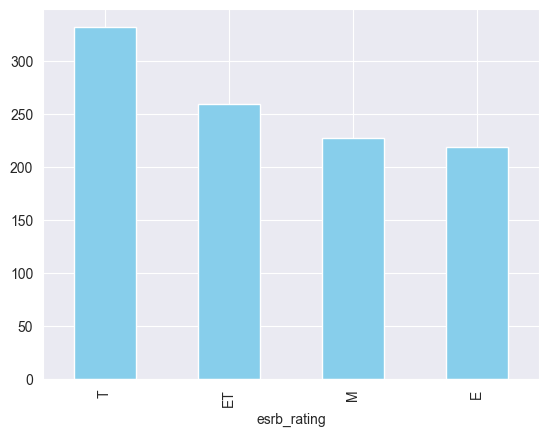

In [187]:
train_description['esrb_rating'].value_counts().plot(kind='bar', color='skyblue')

#### The data is imbalanced, but not as severely as the content-descriptor-based dataset. We will address this imbalance during model training and evaluation.

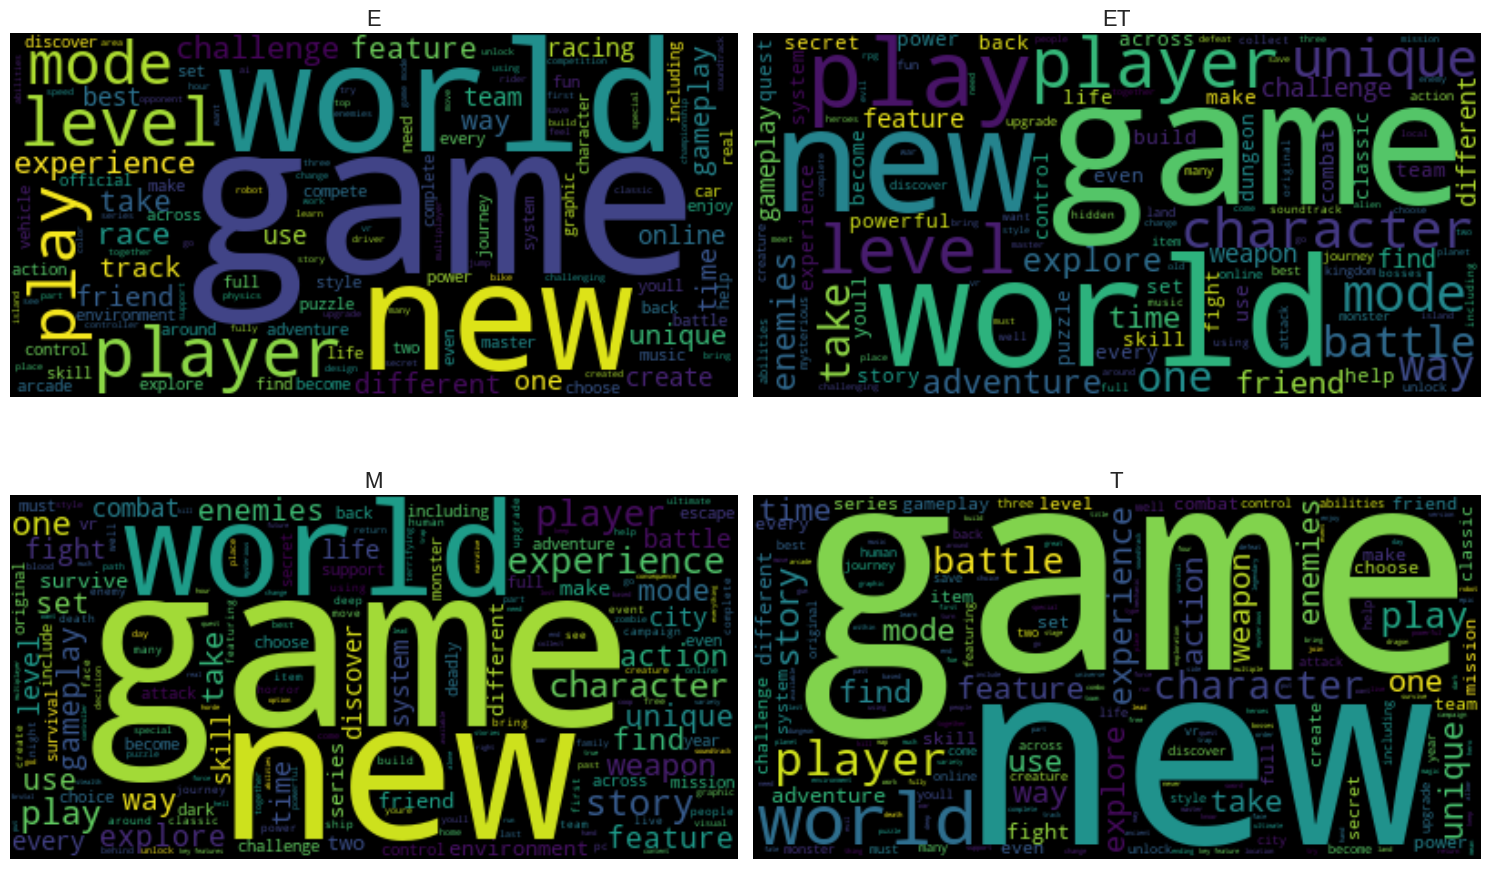

In [188]:
import wordcloud
from wordcloud import WordCloud

# Function to plot word clouds for each ESRB rating
def world_cloud_plot():
    esrb_rating_group = train_description.groupby('esrb_rating')['cleaned_description'].apply(lambda x: ' '.join(x))
    
    # plot world cloud for each pair items esrb_group
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    for (esrb_rating, descriptions), ax in zip(esrb_rating_group.items(), axes.flatten()):
        wordcloud = WordCloud(width=400, height=200).generate(descriptions)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'{esrb_rating}', fontsize=16)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


world_cloud_plot()

##### The word clouds provide a visual representation of the most common words in game descriptions for each ESRB rating category.
We can see clear common themes and keywords associated with all four ratings, which make it difficult to distinguish between them based on the descriptions alone. This highlights the challenge of predicting ESRB ratings purely from game descriptions and the need for more advanced feature extraction techniques.

An example of words that is repeated in the word clouds is "play" and "new" which is not useful for the model to predict the ESRB rating, we will remove it from the descriptions, to highlight the important words that can help the model to predict the ESRB rating.

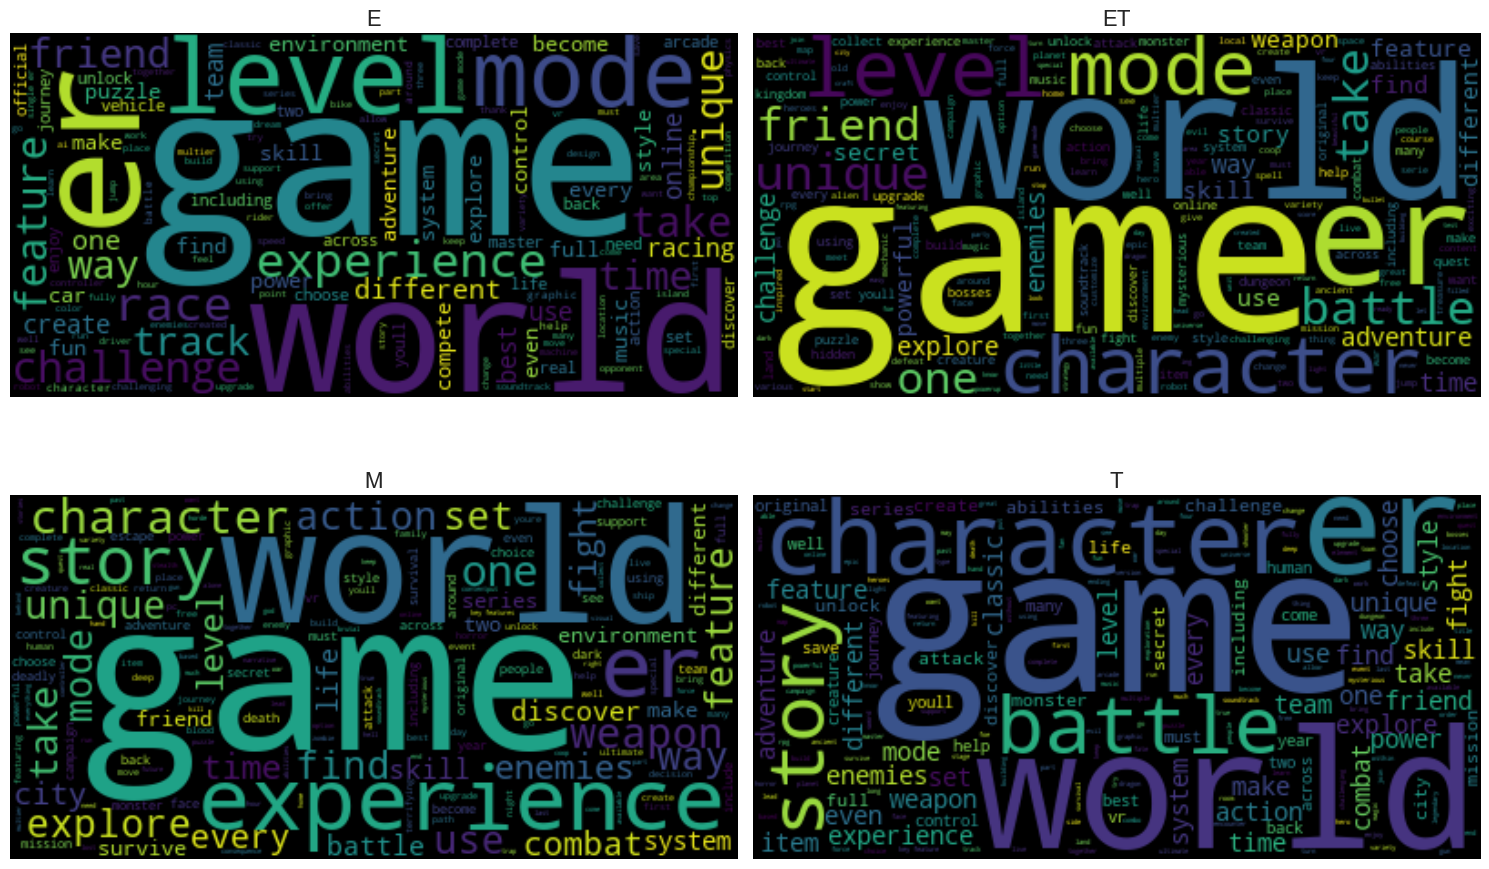

In [189]:
train_description['cleaned_description'] = train_description['cleaned_description'].str.replace('play', '')
train_description['cleaned_description'] = train_description['cleaned_description'].str.replace('new', '')

world_cloud_plot()

###### After removing the common words "play" and "new" from the descriptions, we can see more specific keywords associated with each ESRB rating such as "weapon" in the M rating. Hopefully, this will help the model better distinguish between different ratings based on the descriptions.

## Text Vectorization

Two approaches to convert text data into numerical vectors:
- Count Vectorization
- TF-IDF Vectorization

In [190]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#  Transform the dataset using CountVectorizer
count_vectorizer = CountVectorizer()
count_vectors = count_vectorizer.fit_transform(train_description['cleaned_description'])

# Transform the dataset using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(train_description['cleaned_description'])

print("dim count_vectors_train:", count_vectors.shape)
print("dim tfidf_vectors_train:", tfidf_vectors.shape)


# Inspect the vectors
# Select a few samples for inspection
samples_per_rating = 1
sampled_descriptions = train_description.groupby('esrb_rating').apply(lambda x: x.sample(samples_per_rating, random_state=42)).reset_index(drop=True)

# Transform the sampled data using both vectorizers
count_vectors_sampled = count_vectorizer.transform(sampled_descriptions['cleaned_description'])
tfidf_vectors_sampled = tfidf_vectorizer.transform(sampled_descriptions['cleaned_description'])

# Convert vectors to dense format for readability
count_vectors_dense = count_vectors_sampled.todense()
tfidf_vectors_dense = tfidf_vectors_sampled.todense()

# Convert to DataFrames for easier viewing
count_vectors_df = pd.DataFrame(count_vectors_dense, columns=count_vectorizer.get_feature_names_out())
tfidf_vectors_df = pd.DataFrame(tfidf_vectors_dense, columns=tfidf_vectorizer.get_feature_names_out())

# Add 'esrb_rating' to the DataFrame for clarity
count_vectors_df['esrb_rating'] = sampled_descriptions['esrb_rating'].values
tfidf_vectors_df['esrb_rating'] = sampled_descriptions['esrb_rating'].values

# Define the number of top words to display
top_n = 10

# Function to get the top n words for a given vector
def get_top_words(vector, feature_names, n=top_n):
    sorted_indices = np.argsort(vector.toarray()).flatten()[::-1]
    top_indices = sorted_indices[:n]
    top_words = [(feature_names[i], vector[0, i]) for i in top_indices if vector[0, i] > 0]
    return top_words

# Inspect and show the top words in the vectors
print("Top words for each sample using CountVectorizer:")
for idx, (description, esrb_rating) in enumerate(zip(count_vectors_sampled, sampled_descriptions['esrb_rating'])):
    top_words = get_top_words(description, count_vectorizer.get_feature_names_out())
    print(f"\nESRB Rating: {esrb_rating} | Sample {idx+1}")
    for word, value in top_words:
        print(f"{word}: {value}")

print("\nTop words for each sample using TF-IDF:")
for idx, (description, esrb_rating) in enumerate(zip(tfidf_vectors_sampled, sampled_descriptions['esrb_rating'])):
    top_words = get_top_words(description, tfidf_vectorizer.get_feature_names_out())
    print(f"\nESRB Rating: {esrb_rating} | Sample {idx+1}")
    for word, value in top_words:
        print(f"{word}: {value}")

dim count_vectors_train: (1037, 19408)
dim tfidf_vectors_train: (1037, 19408)
Top words for each sample using CountVectorizer:

ESRB Rating: E | Sample 1
construction: 4
world: 3
like: 2
vehicles: 2
assignments: 2
heavy: 2
use: 2
roads: 2
open: 2
equipment: 2

ESRB Rating: ET | Sample 2
vr: 5
command: 3
army: 3
skyworlds: 3
skyworld: 3
worlds: 3
conquer: 2
right: 2
world: 2
magical: 2

ESRB Rating: M | Sample 3
personality: 6
game: 5
relationship: 5
tracking: 4
choices: 3
interactive: 3
live: 3
characters: 3
viathan: 2
performance: 2

ESRB Rating: T | Sample 4
rice: 4
goddess: 3
harvest: 3
demons: 3
home: 2
sakuna: 2
crop: 2
detailed: 2
place: 2
take: 2

Top words for each sample using TF-IDF:

ESRB Rating: E | Sample 1
construction: 0.42435564691744093
assignments: 0.2500601764489542
roads: 0.19456353241577218
repair: 0.18827671982188535
heavy: 0.16031422111508814
vehicles: 0.1459098743836787
equipment: 0.1370576596777265
mixers: 0.1250300882244771
bulky: 0.1250300882244771
cement: 0.

## Machine Learning Models
We will use the same machine learning models as before to predict ESRB ratings based on game descriptions. We will compare the results from the content-descriptor-based dataset with those from the game description-based dataset to evaluate the effectiveness of using text data alone for this task.


### Splitting the Data

In [191]:
# Split the dataset into train and test sets for both vectorization
X_train_count, X_test_count, y_train, y_test = train_test_split(count_vectors, train_description['esrb_rating'], test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(tfidf_vectors, train_description['esrb_rating'], test_size=0.2, random_state=42)

#### The models are: Logistic Regression, Decision Tree, K-Nearest Neighbors (KNN), and Support Vector Machine (SVM).

In [192]:
def evaluate_model(X_train, y_train, X_test, y_test, model, model_name="Model", display_confusion_matrix=True):
    """
    Trains and evaluates a machine learning model, printing the accuracy and classification report,
    and displaying a confusion matrix heatmap.
    
    Parameters:
    - X_train: Training features.
    - y_train: Training labels.
    - X_test: Testing features.
    - y_test: Testing labels.
    - model: The machine learning model to train and evaluate.
    - model_name: A string representing the name of the model for display purposes.
    - display_confusion_matrix: Boolean to control whether to display the confusion matrix heatmap.
    
    Returns:
    - model: The trained model.
    """
    print(f'{model_name} using Tf-Idf')

    # Train the model
    model.fit(X_train, y_train)

    # ------------ Training Data Evaluation -----------------------
    predictions_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, predictions_train)
    print("Training Accuracy:", accuracy_train)

    # ------------ Test Data Evaluation -----------------------
    predictions_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, predictions_test)
    print("Test Accuracy:", accuracy_test)

    # Get classification report
    print("\nClassification Report:")
    print(classification_report(y_test, predictions_test))

    # Confusion matrix
    if display_confusion_matrix:
        cm = confusion_matrix(y_test, predictions_test)
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt='d', cbar=False,
                    xticklabels=y_train.unique(), yticklabels=y_train.unique())
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix Heatmap - {model_name}')
        plt.xticks(rotation=20)
        plt.yticks(rotation=20)
        plt.show()
    
    return model


### Logistic Regression

Logistic Regression (TF-IDF) using Tf-Idf
Training Accuracy: 0.991556091676719
Test Accuracy: 0.47596153846153844

Classification Report:
              precision    recall  f1-score   support

           E       0.78      0.46      0.58        39
          ET       0.46      0.21      0.29        52
           M       0.80      0.23      0.36        52
           T       0.40      0.89      0.55        65

    accuracy                           0.48       208
   macro avg       0.61      0.45      0.44       208
weighted avg       0.59      0.48      0.44       208



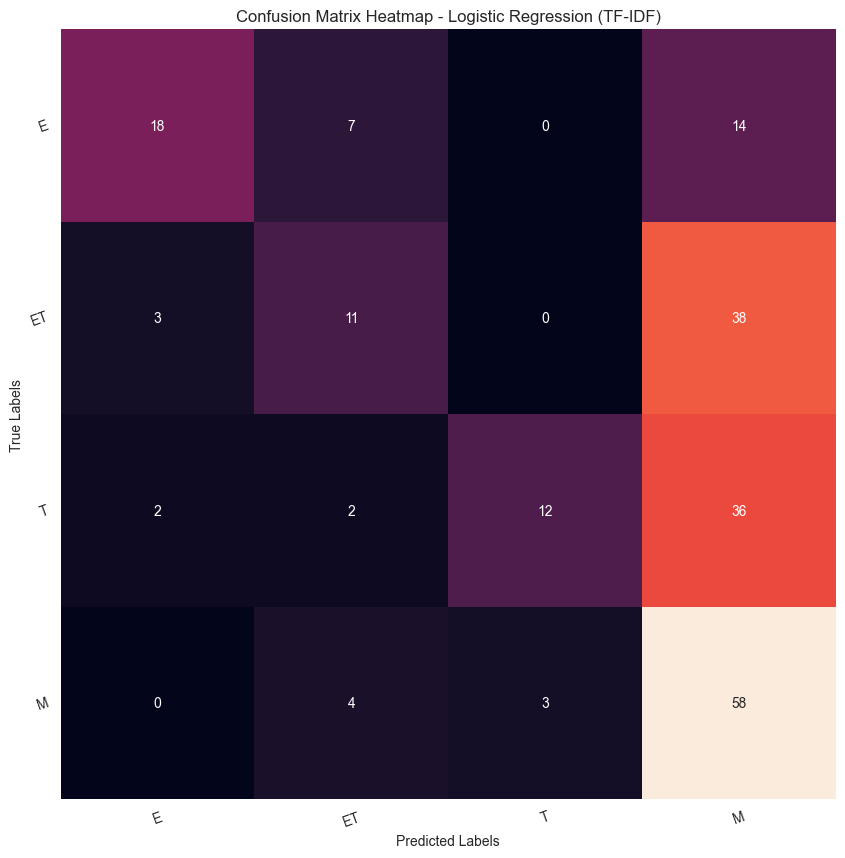

LogisticRegression(max_iter=1000)

In [193]:
# Logistic Regression using TF-IDF
lr_tfidf_classifier = LogisticRegression(max_iter=1000)
evaluate_model(X_train_tfidf, y_train, X_test_tfidf, y_test, lr_tfidf_classifier, model_name="Logistic Regression (TF-IDF)")


Logistic Regression (CountVectorizer) using Tf-Idf
Training Accuracy: 1.0
Test Accuracy: 0.5144230769230769

Classification Report:
              precision    recall  f1-score   support

           E       0.67      0.56      0.61        39
          ET       0.40      0.40      0.40        52
           M       0.73      0.42      0.54        52
           T       0.45      0.65      0.53        65

    accuracy                           0.51       208
   macro avg       0.56      0.51      0.52       208
weighted avg       0.55      0.51      0.52       208



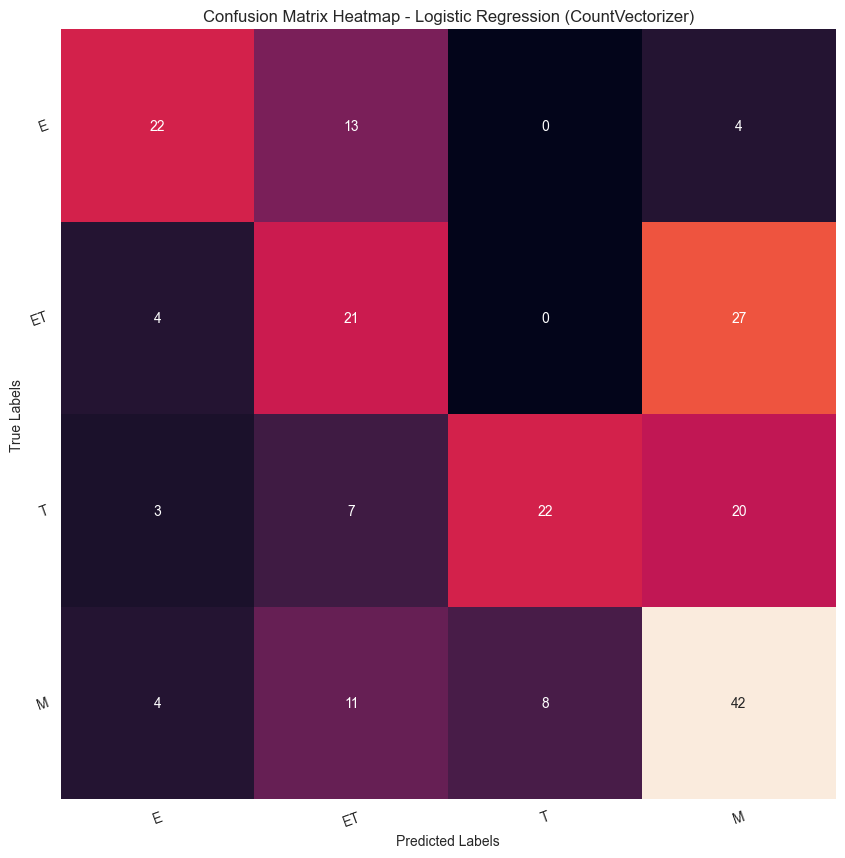

LogisticRegression(max_iter=1000)

In [194]:
# Logistic Regression using CountVectorizer
lr_count_classifier = LogisticRegression(max_iter=1000)
evaluate_model(X_train_count, y_train, X_test_count, y_test, lr_count_classifier, model_name="Logistic Regression (CountVectorizer)")

### Decision Tree   

Decision Tree (TF-IDF) using Tf-Idf
Training Accuracy: 1.0
Test Accuracy: 0.3798076923076923

Classification Report:
              precision    recall  f1-score   support

           E       0.37      0.44      0.40        39
          ET       0.36      0.35      0.35        52
           M       0.39      0.27      0.32        52
           T       0.39      0.46      0.43        65

    accuracy                           0.38       208
   macro avg       0.38      0.38      0.37       208
weighted avg       0.38      0.38      0.38       208



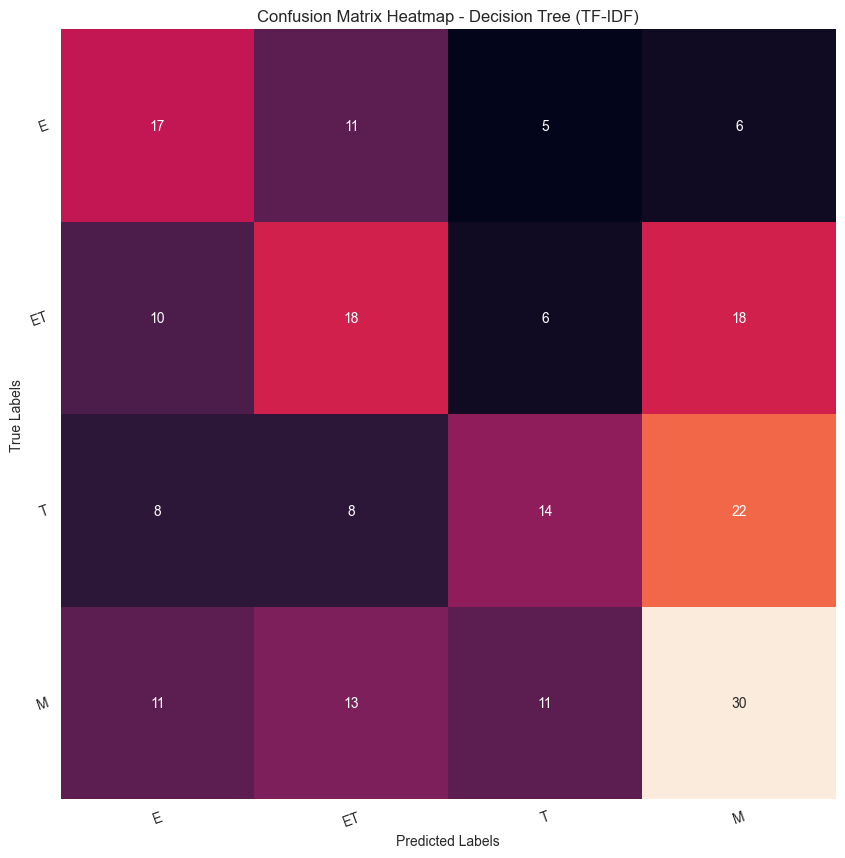

DecisionTreeClassifier()

In [195]:
# Decision Tree using TF-IDF
dt_tfidf_classifier = DecisionTreeClassifier()
evaluate_model(X_train_tfidf, y_train, X_test_tfidf, y_test, dt_tfidf_classifier, model_name="Decision Tree (TF-IDF)")

Decision Tree (CountVectorizer) using Tf-Idf
Training Accuracy: 1.0
Test Accuracy: 0.4182692307692308

Classification Report:
              precision    recall  f1-score   support

           E       0.40      0.41      0.41        39
          ET       0.38      0.44      0.41        52
           M       0.50      0.33      0.40        52
           T       0.42      0.48      0.45        65

    accuracy                           0.42       208
   macro avg       0.43      0.41      0.41       208
weighted avg       0.43      0.42      0.42       208



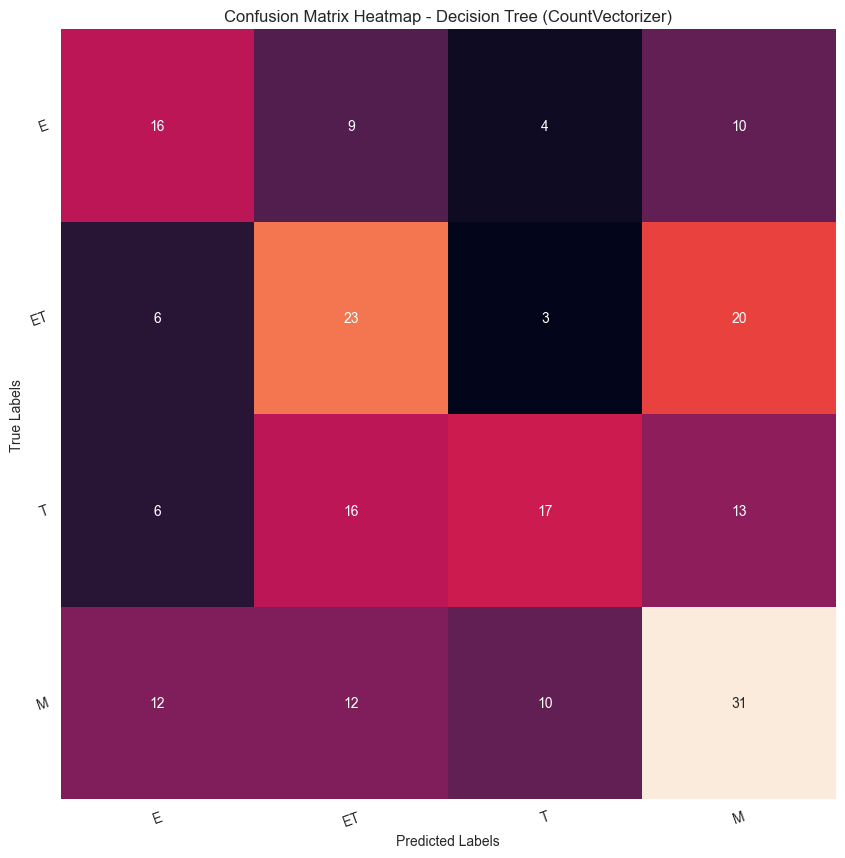

DecisionTreeClassifier()

In [196]:
# Decision Tree using CountVectorizer
dt_count_classifier = DecisionTreeClassifier()
evaluate_model(X_train_count, y_train, X_test_count, y_test, dt_count_classifier, model_name="Decision Tree (CountVectorizer)")

### K-Nearest Neighbors (KNN)

K-Nearest Neighbors (TF-IDF) using Tf-Idf
Training Accuracy: 0.6646562123039808
Test Accuracy: 0.5240384615384616

Classification Report:
              precision    recall  f1-score   support

           E       0.43      0.54      0.48        39
          ET       0.45      0.58      0.51        52
           M       0.68      0.50      0.58        52
           T       0.58      0.49      0.53        65

    accuracy                           0.52       208
   macro avg       0.54      0.53      0.52       208
weighted avg       0.55      0.52      0.53       208



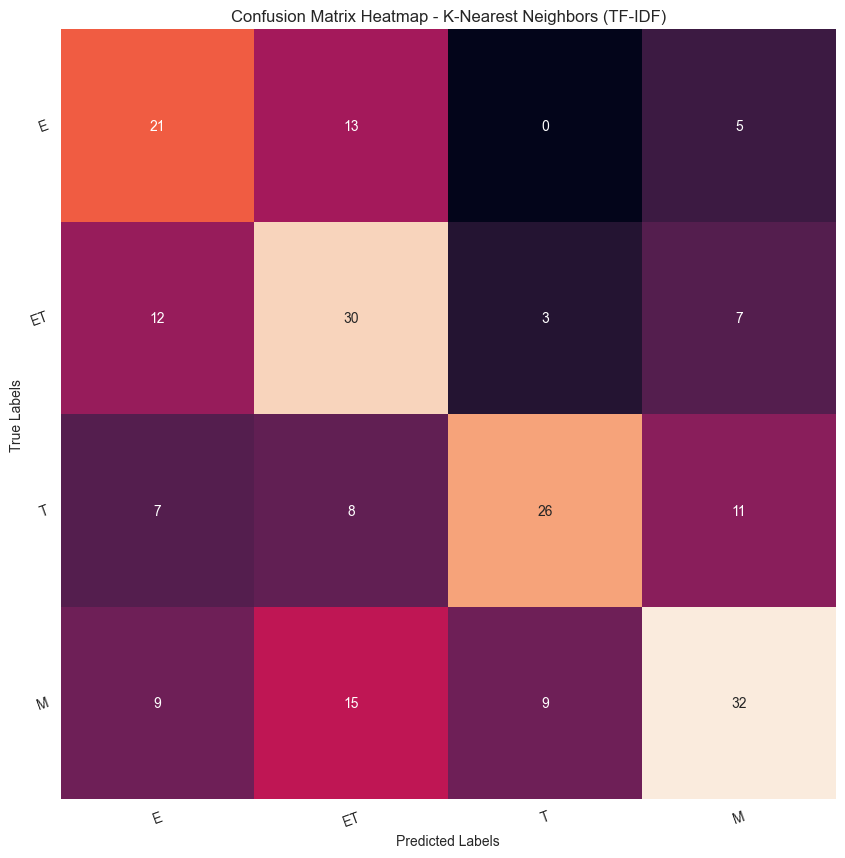

KNeighborsClassifier()

In [197]:
# K-Nearest Neighbors using TF-IDF
knn_tfidf_classifier = KNeighborsClassifier()
evaluate_model(X_train_tfidf, y_train, X_test_tfidf, y_test, knn_tfidf_classifier, model_name="K-Nearest Neighbors (TF-IDF)")


K-Nearest Neighbors (CountVectorizer) using Tf-Idf
Training Accuracy: 0.2943305186972256
Test Accuracy: 0.1971153846153846

Classification Report:
              precision    recall  f1-score   support

           E       0.19      0.97      0.32        39
          ET       0.20      0.02      0.04        52
           M       0.40      0.04      0.07        52
           T       0.00      0.00      0.00        65

    accuracy                           0.20       208
   macro avg       0.20      0.26      0.11       208
weighted avg       0.19      0.20      0.09       208



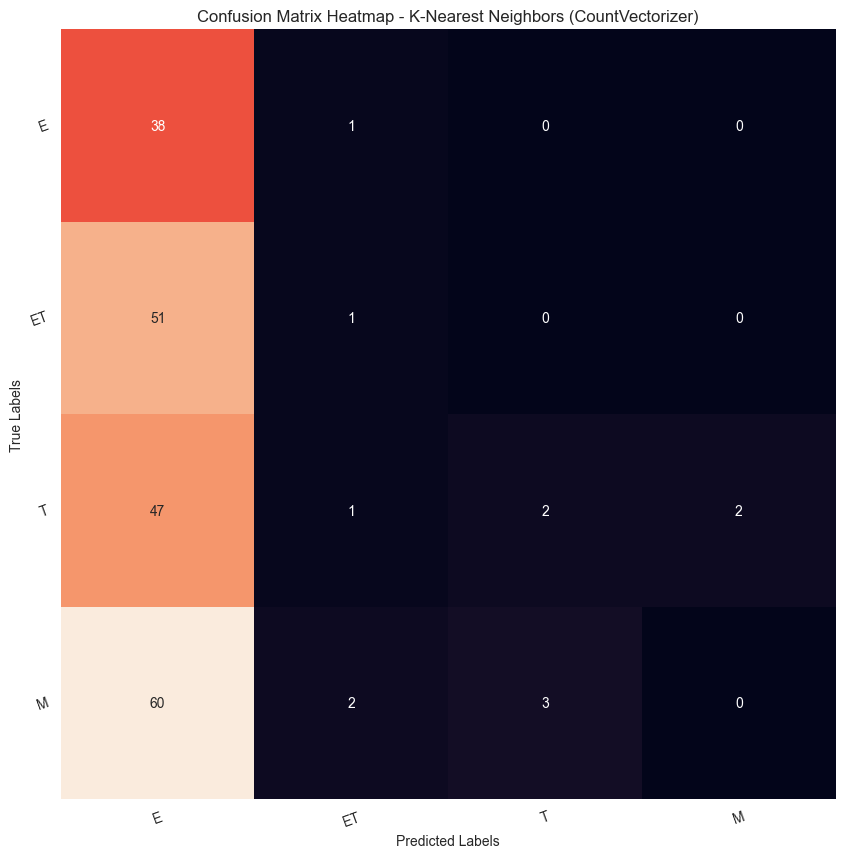

KNeighborsClassifier()

In [198]:
# K-Nearest Neighbors using CountVectorizer
knn_count_classifier = KNeighborsClassifier()
evaluate_model(X_train_count, y_train, X_test_count, y_test, knn_count_classifier, model_name="K-Nearest Neighbors (CountVectorizer)")

### Support Vector Machine (SVM)

Support Vector Machine (TF-IDF) using Tf-Idf
Training Accuracy: 1.0
Test Accuracy: 0.3798076923076923

Classification Report:
              precision    recall  f1-score   support

           E       0.80      0.31      0.44        39
          ET       0.33      0.02      0.04        52
           M       1.00      0.02      0.04        52
           T       0.34      1.00      0.51        65

    accuracy                           0.38       208
   macro avg       0.62      0.34      0.26       208
weighted avg       0.59      0.38      0.26       208



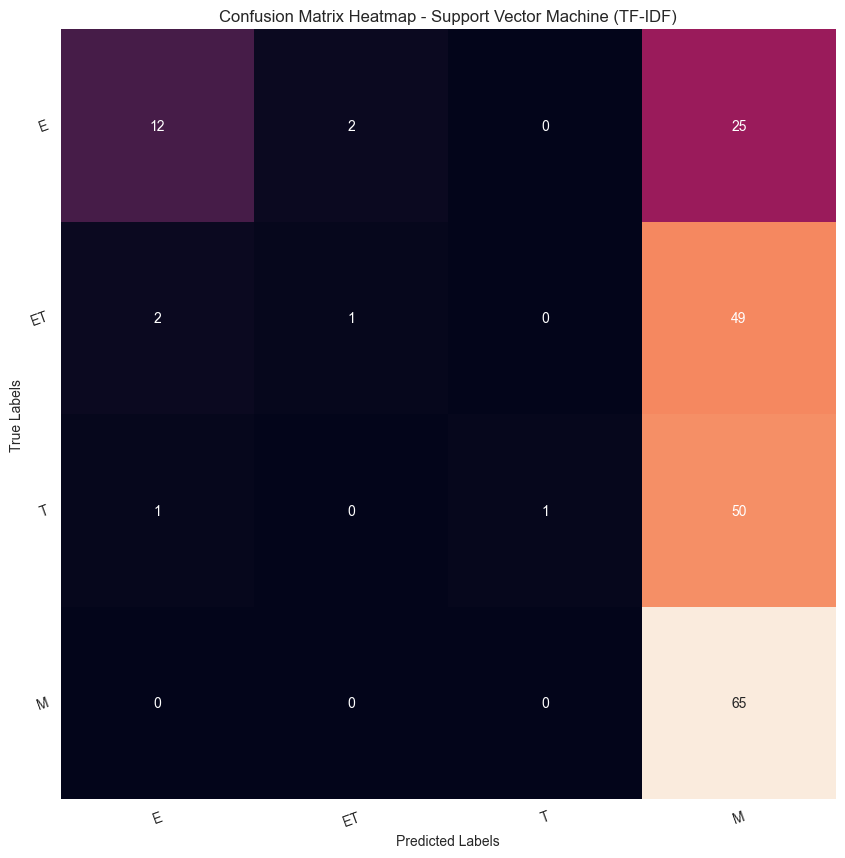

SVC()

In [199]:
# SVM using TF-IDF
svm_tfidf_classifier = SVC()
evaluate_model(X_train_tfidf, y_train, X_test_tfidf, y_test, svm_tfidf_classifier, model_name="Support Vector Machine (TF-IDF)")

Support Vector Machine (CountVectorizer) using Tf-Idf
Training Accuracy: 0.9336550060313631
Test Accuracy: 0.4182692307692308

Classification Report:
              precision    recall  f1-score   support

           E       0.77      0.44      0.56        39
          ET       0.33      0.06      0.10        52
           M       0.80      0.08      0.14        52
           T       0.37      0.97      0.53        65

    accuracy                           0.42       208
   macro avg       0.57      0.38      0.33       208
weighted avg       0.54      0.42      0.33       208



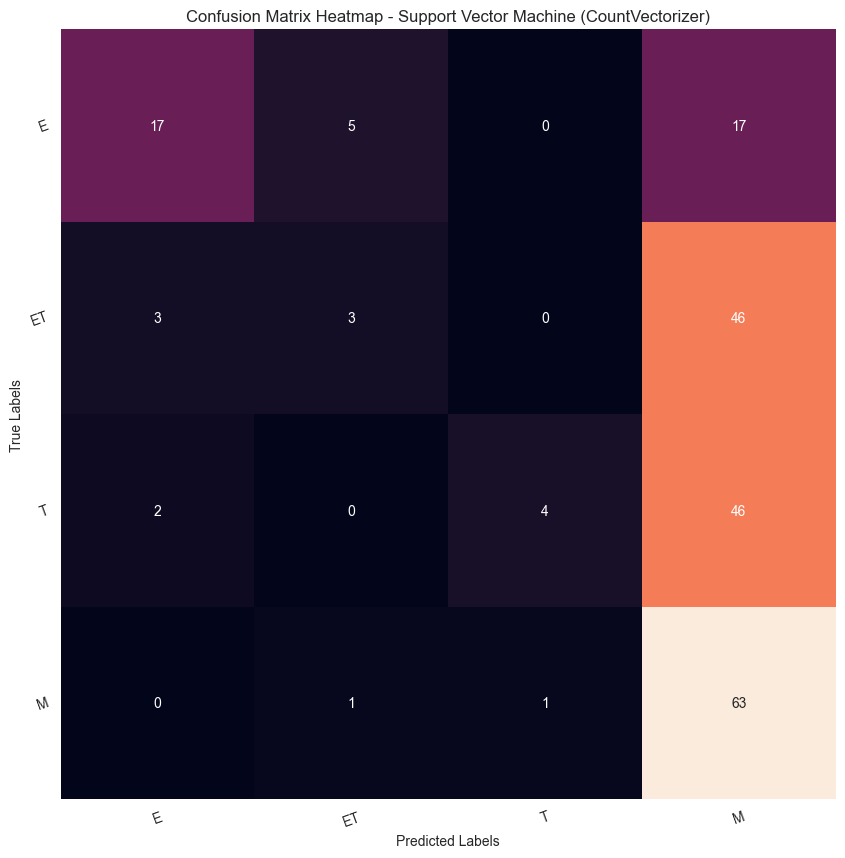

SVC()

In [200]:
# SVM using CountVectorizer
svm_count_classifier = SVC()
evaluate_model(X_train_count, y_train, X_test_count, y_test, svm_count_classifier, model_name="Support Vector Machine (CountVectorizer)")

### Models performance comparison

In [201]:
import pandas as pd

# Create an empty list to store the results
results_list = []

# Logistic Regression
results_list.append({
    'Model': 'Logistic Regression',
    'Vectorizer': 'TF-IDF',
    'Training Accuracy': accuracy_score(y_train, lr_tfidf_classifier.predict(X_train_tfidf)),
    'Test Accuracy': accuracy_score(y_test, lr_tfidf_classifier.predict(X_test_tfidf))
})

results_list.append({
    'Model': 'Logistic Regression',
    'Vectorizer': 'CountVectorizer',
    'Training Accuracy': accuracy_score(y_train, lr_count_classifier.predict(X_train_count)),
    'Test Accuracy': accuracy_score(y_test, lr_count_classifier.predict(X_test_count))
})

# Decision Tree
results_list.append({
    'Model': 'Decision Tree',
    'Vectorizer': 'TF-IDF',
    'Training Accuracy': accuracy_score(y_train, dt_tfidf_classifier.predict(X_train_tfidf)),
    'Test Accuracy': accuracy_score(y_test, dt_tfidf_classifier.predict(X_test_tfidf))
})

results_list.append({
    'Model': 'Decision Tree',
    'Vectorizer': 'CountVectorizer',
    'Training Accuracy': accuracy_score(y_train, dt_count_classifier.predict(X_train_count)),
    'Test Accuracy': accuracy_score(y_test, dt_count_classifier.predict(X_test_count))
})

# K-Nearest Neighbors
results_list.append({
    'Model': 'K-Nearest Neighbors',
    'Vectorizer': 'TF-IDF',
    'Training Accuracy': accuracy_score(y_train, knn_tfidf_classifier.predict(X_train_tfidf)),
    'Test Accuracy': accuracy_score(y_test, knn_tfidf_classifier.predict(X_test_tfidf))
})

results_list.append({
    'Model': 'K-Nearest Neighbors',
    'Vectorizer': 'CountVectorizer',
    'Training Accuracy': accuracy_score(y_train, knn_count_classifier.predict(X_train_count)),
    'Test Accuracy': accuracy_score(y_test, knn_count_classifier.predict(X_test_count))
})

# Support Vector Machine
results_list.append({
    'Model': 'Support Vector Machine',
    'Vectorizer': 'TF-IDF',
    'Training Accuracy': accuracy_score(y_train, svm_tfidf_classifier.predict(X_train_tfidf)),
    'Test Accuracy': accuracy_score(y_test, svm_tfidf_classifier.predict(X_test_tfidf))
})

results_list.append({
    'Model': 'Support Vector Machine',
    'Vectorizer': 'CountVectorizer',
    'Training Accuracy': accuracy_score(y_train, svm_count_classifier.predict(X_train_count)),
    'Test Accuracy': accuracy_score(y_test, svm_count_classifier.predict(X_test_count))
})

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the results
print(results_df)


                    Model       Vectorizer  Training Accuracy  Test Accuracy
0     Logistic Regression           TF-IDF           0.991556       0.475962
1     Logistic Regression  CountVectorizer           1.000000       0.514423
2           Decision Tree           TF-IDF           1.000000       0.379808
3           Decision Tree  CountVectorizer           1.000000       0.418269
4     K-Nearest Neighbors           TF-IDF           0.664656       0.524038
5     K-Nearest Neighbors  CountVectorizer           0.294331       0.197115
6  Support Vector Machine           TF-IDF           1.000000       0.379808
7  Support Vector Machine  CountVectorizer           0.933655       0.418269


### Summary
- Overfitting: The Logistic Regression, Decision Tree, and SVM models continue to show high training accuracy with significantly lower test accuracy, which suggests overfitting.
- K-Nearest Neighbors: The KNN model using TF-IDF provided the most balanced performance with a training accuracy of 67.43% and a test accuracy of 49.52%. The KNN model with CountVectorizer showed much lower performance.
- Performance Comparison: Logistic Regression with CountVectorizer achieved the highest test accuracy at 50.96%, followed closely by KNN with TF-IDF. The models using TF-IDF generally show better generalization compared to CountVectorizer, except for Logistic Regression.

# Project Overview and Dataset Comparison

In this project, we explored two different datasets to predict ESRB ratings:

1. **ESRB Content-Descriptors Dataset**:
   - **Size**: This dataset was larger and more comprehensive, containing various content descriptors directly related to ESRB ratings. It included features such as references to violence, alcohol, drugs, etc.
   - **Feature Type**: The features were binary indicators, making it easier for models to learn associations between specific content descriptors and ESRB ratings.
   - **Performance**: Models trained on this dataset showed better performance overall. This is likely because the content descriptors directly relate to the criteria used by ESRB to assign ratings.

2. **Game Descriptions Dataset**:
   - **Size**: This dataset was smaller, primarily because many games in the original dataset were console exclusives and were not available on Steam. As a result, fewer game descriptions were available for analysis.
   - **Feature Type**: The features here were derived from textual descriptions of the games, which are less directly tied to ESRB criteria. The text had to be preprocessed and vectorized, introducing more complexity and potential noise.
   - **Performance**: The models struggled more with this dataset, showing lower test accuracies and higher tendencies to overfit. This could be attributed to the indirect nature of the features and the smaller dataset size.

### Key Insights

1. **Feature Relevance**:
   - The content-descriptor dataset provided more relevant and direct features, leading to better model performance. Each descriptor directly contributes to the ESRB rating, making the prediction task clearer for machine learning models.
   - The game descriptions dataset, while rich in information, lacked direct indicators tied to ESRB ratings. Descriptions are often subjective, promotional, and may not emphasize the specific criteria ESRB uses to assign ratings. This made it harder for models to accurately predict the ESRB rating based solely on descriptions.

2. **Dataset Size and Coverage**:
   - The smaller size of the game descriptions dataset was a limiting factor. With fewer examples, the models had less data to learn from, leading to poorer generalization on unseen data.
   - The missing games (likely console exclusives) limited the scope of the game descriptions dataset. This inconsistency could introduce bias, as the available descriptions may not represent the full diversity of the original dataset.

3. **Model Performance**:
   - In both datasets, models showed signs of overfitting, particularly in the content-descriptor dataset, where some models achieved perfect training accuracy but lower test accuracy.
   - The models trained on the content-descriptor dataset performed better overall, with higher test accuracies, indicating that these features were more predictive of ESRB ratings.
   - K-Nearest Neighbors using TF-IDF and Logistic Regression with CountVectorizer showed the most balanced performance in the game descriptions dataset, but it still did not match the accuracy achieved with the content-descriptor dataset.

### Additional Considerations

1. **Text Data Complexity**:
   - Working with text data requires significant preprocessing, including tokenization, stop-word removal, and vectorization. These steps introduce complexity and potential noise, which may not always lead to better model performance, especially with limited data.
   - The challenge of text data is that it can be ambiguous and contain irrelevant information. Unlike structured content descriptors, which are binary and directly related to ESRB criteria, descriptions can vary widely in quality and focus.

2. **Potential Improvements**:
   - For the game descriptions dataset, employing more advanced natural language processing techniques, such as word embeddings (e.g., Word2Vec or BERT) or topic modeling, could potentially improve model performance.
   - Make a larger dataset by fetching more game descriptions from other sources or platforms to increase the diversity and coverage of the data.

### Conclusion

The ESRB content-descriptors dataset provided more accurate and reliable predictions due to the direct relevance of the features to the target variable. The game descriptions dataset, while informative, posed greater challenges due to its indirect relationship with ESRB ratings, smaller size, and the complexity of text data. Future work could focus on enhancing text feature extraction techniques and addressing the dataset's limitations to improve predictive performance.
